In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('US SALES.xlsx')
df.head()

,Order Date,Subject Category,Sales Amount,Sales Quantity
0,2020-01-01,Science & Technology,30734.01,581
1,2020-01-02,Science & Technology,50991.12,1015
2,2020-01-03,Science & Technology,50222.00,999
3,2020-01-04,Science & Technology,33865.67,661
4,2020-01-05,Science & Technology,38874.10,748


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order Date        2192 non-null   datetime64[ns]
 1   Subject Category  2192 non-null   object        
 2   Sales Amount      2192 non-null   float64       
 3   Sales Quantity    2192 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 68.6+ KB


In [4]:
df_holidays = pd.read_excel('US HOLIDAY.xlsx')
df_holidays.head()

,Date,Holiday
0,2020-01-01,New Year's Day
1,2020-01-20,Martin Luther King Jr. Day
2,2020-02-17,Washington's Birthday / Presidents Day
3,2020-05-25,Memorial Day
4,2020-07-03,Independence Day (observed)


In [5]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     32 non-null     datetime64[ns]
 1   Holiday  32 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 644.0+ bytes


In [6]:
df1 = df.copy()
df1['isholiday'] = df1['Order Date'].isin(df_holidays['Date']).astype(int)


In [7]:
df_holidays.head()

,Date,Holiday
0,2020-01-01,New Year's Day
1,2020-01-20,Martin Luther King Jr. Day
2,2020-02-17,Washington's Birthday / Presidents Day
3,2020-05-25,Memorial Day
4,2020-07-03,Independence Day (observed)


In [8]:
name = df_holidays.set_index('Date')['Holiday']
df1['holiday_name'] = df1['Order Date'].map(name)
df1['holiday_name'] = df1['holiday_name'].fillna('Normal Day')

# FORECASTING

## <left><div style="font-family: Trebuchet MS; background-color: #F5C6EC; color: #2D2926; padding: 12px; line-height: 1;">Random Forest</div></left>

In [567]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

In [568]:
df1.columns

Index(['Order Date', 'Subject Category', 'Sales Amount', 'Sales Quantity',
       'isholiday', 'holiday_name'],
      dtype='object')

In [569]:
daily = df1.copy()

In [570]:
from sklearn.preprocessing import OneHotEncoder
tipe_holiday= ['holiday_name']  
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
holiday_ohe = enc.fit_transform(daily[tipe_holiday])
holiday_ohe_cols = enc.get_feature_names_out(tipe_holiday)
holiday_ohe_df = pd.DataFrame(
    holiday_ohe,
    columns=holiday_ohe_cols,
    index=daily.index
)

daily = pd.concat([daily, holiday_ohe_df], axis=1)


In [571]:
tipe_category= ['Subject Category']
cat = enc.fit_transform(daily[tipe_category])
cat_cols = enc.get_feature_names_out(tipe_category)
cat_df = pd.DataFrame(
    cat,
    columns=cat_cols,
    index=daily.index
)
daily = pd.concat([daily, cat_df], axis=1)

In [572]:
daily = df1.groupby(['Order Date', 'Subject Category'])[[ 'Sales Amount', 'Sales Quantity']].sum().reset_index().sort_values('Order Date')

In [607]:
for lag in [3, 7, 14, 28,30,90,180,365]:
    daily[f'amount_lag_{lag}'] = (daily.groupby('Subject Category')['Sales Amount'].shift(lag))

    daily[f'qty_lag_{lag}'] = (daily.groupby('Subject Category')['Sales Quantity'].shift(lag))


In [608]:
for window in [3, 7, 14, 28, 30,90,180,365]:
    daily[f'amount_rolling_mean_{window}'] = daily.groupby('Subject Category')['Sales Amount'].shift(1).rolling(window).mean()
    daily[f'amount_rolling_std_{window}'] = daily.groupby('Subject Category')['Sales Amount'].shift(1).rolling(window).std()
    daily[f'qty_rolling_mean_{window}'] = daily.groupby('Subject Category')['Sales Quantity'].shift(1).rolling(window).mean()
    daily[f'qty_rolling_std_{window}'] = daily.groupby('Subject Category')['Sales Quantity'].shift(1).rolling(window).std()


In [609]:
daily['dayofweek'] = daily['Order Date'].dt.dayofweek
daily['month'] = daily['Order Date'].dt.month
daily['weekofyear'] = daily['Order Date'].dt.isocalendar().week.astype(int)


In [610]:
len(daily)

2192

**One Hot encoder**

In [611]:
model_df = daily.dropna().reset_index(drop=True)
#model_df= pd.DataFrame(model_df.resample('w')[['Sales Quantity']].sum().round(2))

In [612]:
model_df = model_df.sort_values(
    by=['Order Date']
).reset_index(drop=True)

In [613]:
model_df= model_df.drop(columns=[ 'Subject Category'])

In [614]:
qty = 'Sales Quantity'
amt = 'Sales Amount'

In [615]:
drop_cols = [
    'Sales Quantity',
    'Sales Amount',
    'Order Date']

X = model_df.drop(columns=drop_cols)
y_qty = model_df[qty]
y_amt = model_df[amt]


In [616]:
X.head()

,amount_lag_3,qty_lag_3,amount_lag_7,qty_lag_7,amount_lag_14,qty_lag_14,amount_lag_28,qty_lag_28,amount_rolling_mean_3,amount_rolling_std_3,...,qty_rolling_mean_90,qty_rolling_std_90,amount_rolling_mean_180,amount_rolling_std_180,qty_rolling_mean_180,qty_rolling_std_180,amount_rolling_mean_365,amount_rolling_std_365,qty_rolling_mean_365,qty_rolling_std_365
0,68333.46,1124.0,28414.80,452.0,51793.38,885.0,40468.96,688.0,57144.760000,22006.440033,...,482.522222,261.555083,24364.034889,14633.313566,435.172222,240.343930,37768.159973,29506.395348,667.821918,488.402693
1,32987.77,638.0,11267.43,219.0,20551.15,374.0,11695.86,215.0,47537.930000,24014.651970,...,483.922222,261.981140,24487.643000,14626.293793,437.366667,240.263401,37706.411671,29489.065116,666.991781,488.216723
2,63544.84,990.0,21915.25,380.0,47778.32,836.0,43069.28,706.0,66032.626667,27869.241415,...,490.044444,271.189594,24775.825944,15352.517707,440.133333,245.659627,37860.384493,29605.321646,668.460274,488.889684
3,32647.71,617.0,10582.34,201.0,24891.53,482.0,12894.53,247.0,49982.833333,33257.624679,...,493.255556,269.301325,24871.331500,15312.889120,441.744444,244.953356,37799.986521,29604.739034,667.550685,488.932601
4,34724.35,625.0,18009.12,344.0,20432.99,413.0,10844.86,213.0,47814.923333,34919.996512,...,492.522222,269.119214,24882.636833,15314.615992,441.783333,244.966245,37803.548219,29603.504732,667.482192,488.950724


In [617]:
n = len(X)
test_size = int(0.25 * n)

X_train = X.iloc[:-test_size]
X_test  = X.iloc[-test_size:]

y_qty_train = y_qty.iloc[:-test_size]
y_qty_test  = y_qty.iloc[-test_size:]

y_amt_train = y_amt.iloc[:-test_size]
y_amt_test  = y_amt.iloc[-test_size:]

In [618]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [619]:
from sklearn.ensemble import RandomForestRegressor

rf_qty = RandomForestRegressor(
    n_estimators=300,
    random_state=100,
    n_jobs=-1
)
rf_amt = RandomForestRegressor(
    n_estimators=100,
    random_state=100,
    n_jobs=-1
)

rf_qty.fit(X_train_scaled, y_qty_train)
rf_amt.fit(X_train_scaled, y_amt_train)


RandomForestRegressor(n_jobs=-1, random_state=100)

In [620]:
y_qty_pred = rf_qty.predict(X_test_scaled)
y_amt_pred = rf_amt.predict(X_test_scaled)

In [621]:
import numpy as np
from sklearn.metrics import mean_squared_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Quantity
rmse_qty = mean_squared_error(y_qty_test, y_qty_pred, squared=False)
mape_qty = mape(y_qty_test, y_qty_pred)
r2_qty = r2_score(y_qty_test, y_qty_pred)
# Amount
rmse_amt = mean_squared_error(y_amt_test, y_amt_pred, squared=False)
mape_amt = mape(y_amt_test, y_amt_pred)
r2_amt = r2_score(y_amt_test, y_amt_pred)


print(f'QTY  - RMSE: {rmse_qty:.2f}, MAPE: {mape_qty:.2f}%, R2: {r2_qty:.2f}')
print(f'AMT  - RMSE: {rmse_amt:.2f}, MAPE: {mape_amt:.2f}% R2: {r2_amt:.2f}')

QTY  - RMSE: 146.83, MAPE: 32.21%, R2: 0.62
AMT  - RMSE: 7696.25, MAPE: 29.72% R2: 0.67


HYPER TUNING

In [622]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [8, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', None]
}
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=3)


In [623]:
rf_qty = RandomForestRegressor(
      n_estimators=500,
    max_depth=10,
    min_samples_leaf=10,
    random_state=100,
    n_jobs=-1
)

rand_search_qty = RandomizedSearchCV(
    estimator=rf_qty,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

rand_search_qty.fit(X_train_scaled, y_qty_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(max_depth=10,
                                                   min_samples_leaf=10,
                                                   n_estimators=500, n_jobs=-1,
                                                   random_state=100),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [8, 10, 12, 15, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [624]:
rf_amt = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=10,
    random_state=100,
    n_jobs=-1
)

rand_search_amt = RandomizedSearchCV(
    estimator=rf_amt,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)


rand_search_amt.fit(X_train_scaled, y_amt_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(max_depth=10,
                                                   min_samples_leaf=10,
                                                   n_estimators=500, n_jobs=-1,
                                                   random_state=100),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [8, 10, 12, 15, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [870]:
best_rf_qty = rand_search_qty.best_estimator_
best_rf_amt = rand_search_amt.best_estimator_

print("Best params QTY:", rand_search_qty.best_params_)
print("Best params AMT:", rand_search_amt.best_params_)


Best params QTY: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 8}
Best params AMT: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 8}


In [ ]:
y_qty_pred_tuned = best_rf_qty.predict(X_test_scaled)
y_amt_pred_tuned = best_rf_amt.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
rmse_qty_tuned = mean_squared_error(y_qty_test, y_qty_pred_tuned, squared=False)
mae_qty_tuned = mean_absolute_error(y_qty_test, y_qty_pred_tuned)
mape_qty_tuned = mape(y_qty_test, y_qty_pred_tuned)
rmse_amt_tuned = mean_squared_error(y_amt_test, y_amt_pred_tuned, squared=False)
mae_amt_tuned = mean_absolute_error(y_amt_test, y_amt_pred_tuned)
mape_amt_tuned = mape(y_amt_test, y_amt_pred_tuned)
print(f'Tuned QTY  - RMSE: {rmse_qty_tuned:.2f}, MAPE: {mape_qty_tuned:.2f}%, MAE: {mae_qty_tuned:.2f}')
print(f'Tuned AMT  - RMSE: {rmse_amt_tuned:.2f}, MAPE: {mape_amt_tuned:.2f}%, MAE: {mae_amt_tuned:.2f}')



Tuned QTY  - RMSE: 146.07, MAPE: 32.20%, MAE: 90.42
Tuned AMT  - RMSE: 7884.67, MAPE: 29.30%, MAE: 5115.43


In [874]:
feature_names = X_train.columns

fi_qty = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf_qty.feature_importances_
}).sort_values(by='importance', ascending=False)

fi_qty.head(15)


,feature,importance
3,qty_lag_7,0.576347
2,amount_lag_7,0.090633
10,qty_rolling_mean_3,0.044984
16,amount_rolling_mean_14,0.042839
8,amount_rolling_mean_3,0.022140
5,qty_lag_14,0.018694
1,qty_lag_3,0.014523
26,weekofyear,0.013098
27,amount_lag_30,0.012848
34,qty_lag_365,0.012503


In [875]:
fi_amt = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf_amt.feature_importances_
}).sort_values(by='importance', ascending=False)

fi_amt.head(15)

,feature,importance
2,amount_lag_7,0.650568
34,qty_lag_365,0.058184
8,amount_rolling_mean_3,0.036081
3,qty_lag_7,0.027469
33,amount_lag_365,0.021950
24,dayofweek,0.015554
4,amount_lag_14,0.013839
10,qty_rolling_mean_3,0.012702
26,weekofyear,0.012070
41,qty_rolling_mean_90,0.011617


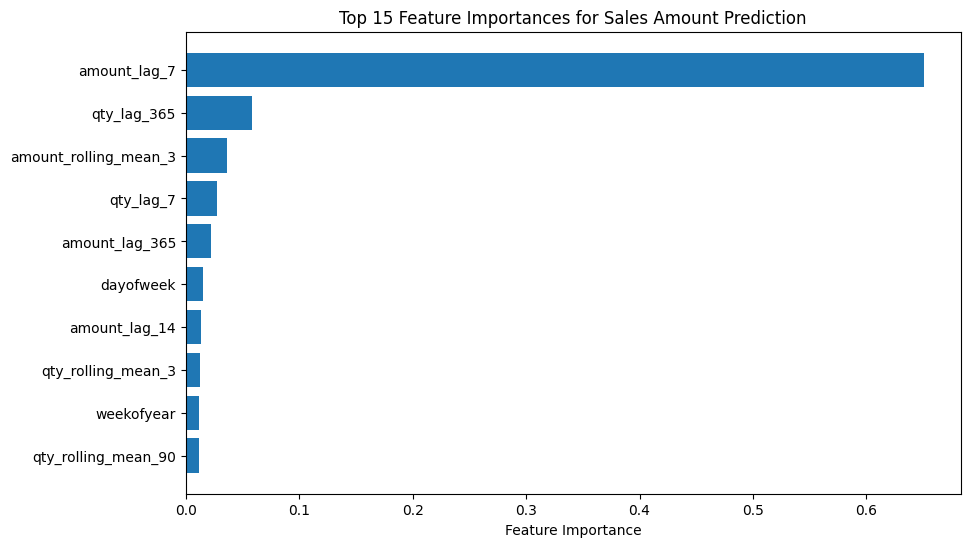

In [637]:
plt.figure(figsize=(10, 6))
plt.barh(fi_amt['feature'][:10][::-1], fi_amt['importance'][:10][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances for Sales Amount Prediction')
plt.show()


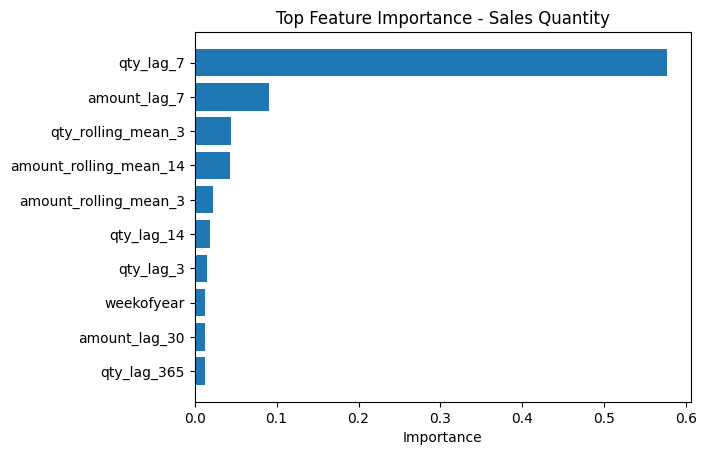

In [638]:
top_n = 10

plt.figure()
plt.barh(
    fi_qty['feature'][:top_n][::-1],
    fi_qty['importance'][:top_n][::-1]
)
plt.title('Top Feature Importance - Sales Quantity')
plt.xlabel('Importance')
plt.show()


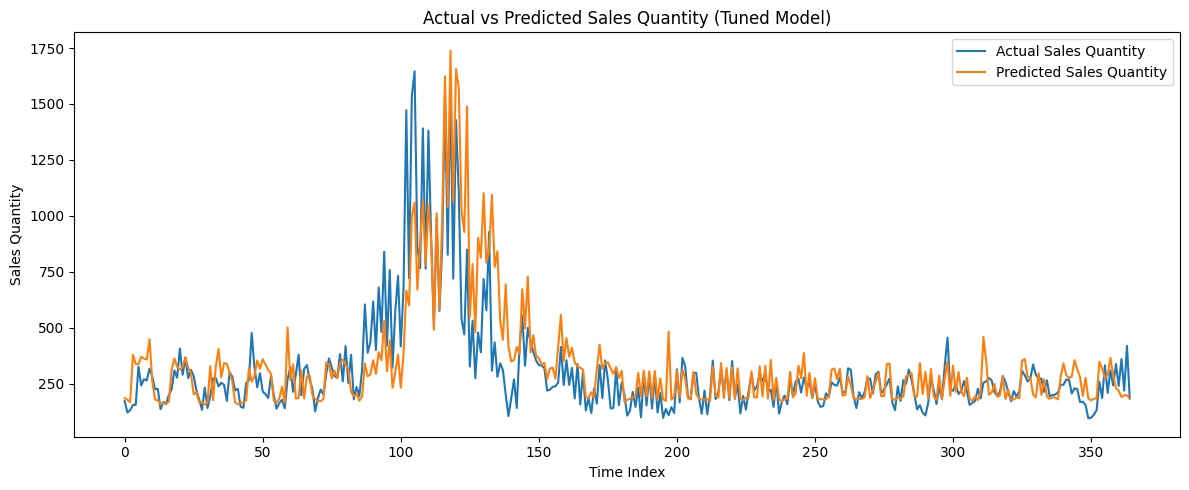

In [639]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_qty_test.values, label='Actual Sales Quantity')
plt.plot(y_qty_pred, label='Predicted Sales Quantity')
plt.title('Actual vs Predicted Sales Quantity (Tuned Model)')
plt.xlabel('Time Index')
plt.ylabel('Sales Quantity')
plt.legend()
plt.tight_layout()
plt.show()


In [656]:
X_cols = X.columns  # X ini dari training

In [657]:
weekly = model_df.groupby(pd.Grouper(key='Order Date', freq='W-MON')).agg({
    'Sales Quantity': 'sum',
    'Sales Amount': 'sum'
}).reset_index()
len(monthly)

105

In [658]:
model_df.head()

,Order Date,Sales Amount,Sales Quantity,amount_lag_3,qty_lag_3,amount_lag_7,qty_lag_7,amount_lag_14,qty_lag_14,amount_lag_28,...,qty_rolling_mean_90,qty_rolling_std_90,amount_rolling_mean_180,amount_rolling_std_180,qty_rolling_mean_180,qty_rolling_std_180,amount_rolling_mean_365,amount_rolling_std_365,qty_rolling_mean_365,qty_rolling_std_365
0,2020-12-31,88131.80,1159,68333.46,1124.0,28414.80,452.0,51793.38,885.0,40468.96,...,482.522222,261.555083,24364.034889,14633.313566,435.172222,240.343930,37768.159973,29506.395348,667.821918,488.402693
1,2020-12-31,27092.35,479,32987.77,638.0,11267.43,219.0,20551.15,374.0,11695.86,...,483.922222,261.981140,24487.643000,14626.293793,437.366667,240.263401,37706.411671,29489.065116,666.991781,488.216723
2,2021-01-01,44107.40,753,63544.84,990.0,21915.25,380.0,47778.32,836.0,43069.28,...,490.044444,271.189594,24775.825944,15352.517707,440.133333,245.659627,37860.384493,29605.321646,668.460274,488.889684
3,2021-01-01,28220.62,526,32647.71,617.0,10582.34,201.0,24891.53,482.0,12894.53,...,493.255556,269.301325,24871.331500,15312.889120,441.744444,244.953356,37799.986521,29604.739034,667.550685,488.932601
4,2021-01-02,29933.17,584,34724.35,625.0,18009.12,344.0,20432.99,413.0,10844.86,...,492.522222,269.119214,24882.636833,15314.615992,441.783333,244.966245,37803.548219,29603.504732,667.482192,488.950724


In [659]:
drop_cols = [
    'Sales Quantity',
    'Sales Amount',
    'Order Date']

X = model_df.drop(columns=drop_cols)
y_qty = model_df[qty]
y_amt = model_df[amt]

In [676]:
def update_features(row, last_rows, target='Sales Quantity', lags=[3, 7, 14, 28,30,90,180,365], rollings=[3, 7, 14, 28,30,90,180,365]):

    for lag in lags:
        if len(last_rows) >= lag:
            row[f'lag_{lag}'] = last_rows[target].iloc[-lag]
        else:
            row[f'lag_{lag}'] = last_rows[target].mean()  # fallback
    for window in rollings:
        if len(last_rows) >= window:
            row[f'rolling_{window}'] = last_rows[target].iloc[-window:].mean()
        else:
            row[f'rolling_{window}'] = last_rows[target].mean()
    row['is_holiday'] = int(row['Order Date'] in df_holidays['Date'].values)
    df1 = df.copy()
    #df1['isholiday'] = df1['Order Date'].isin(df_holidays['Date']).astype(int)
    row['week_of_year'] = row['Order Date'].weekofyear
    row['month'] = row['Order Date'].month

    return row


In [677]:
n_weeks = 52
last_date = model_df['Order Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=n_weeks, freq='W-MON')
future_df = pd.DataFrame({'Order Date': future_dates})
future_df['dayofweek'] = future_df['Order Date'].dt.dayofweek
future_df['month'] = future_df['Order Date'].dt.month
future_df['weekofyear'] = future_df['Order Date'].dt.isocalendar().week
future_df['quarter'] = future_df['Order Date'].dt.quarter
future_df['year'] = future_df['Order Date'].dt.year
future_df['is_weekend'] = future_df['dayofweek'].isin([5,6]).astype(int)
future_df['Sales Quantity'] = np.nan
future_df['Sales Amount'] = np.nan


In [678]:
for col in X_cols:
    if col not in future_df.columns:
        future_df[col] = 0  


In [679]:
rf_qty = rand_search_qty.best_estimator_ 
rf_amt = rand_search_amt.best_estimator_

In [680]:
import warnings
warnings.filterwarnings("ignore")


In [681]:
pred_qty = []
pred_amt = []
last_rows = model_df.copy()

for i in range(n_weeks):
    row = future_df.iloc[i].copy()

    row = update_features(row, last_rows, target='Sales Quantity')
    row = update_features(row, last_rows, target='Sales Amount')

    X_row = row[X_cols].values.reshape(1,-1)
    X_row_scaled = scaler.transform(X_row)

    qty_pred = rf_qty.predict(X_row_scaled)[0]
    amt_pred = rf_amt.predict(X_row_scaled)[0]
    
    future_df.at[i,'Sales Quantity'] = qty_pred
    future_df.at[i,'Sales Amount'] = amt_pred
    pred_qty.append(qty_pred)
    pred_amt.append(amt_pred)
    

    last_rows = pd.concat([last_rows, pd.DataFrame([row])], ignore_index=True)
    last_rows.at[last_rows.index[-1], 'Sales Quantity'] = qty_pred
    last_rows.at[last_rows.index[-1], 'Sales Amount'] = amt_pred


In [682]:
forecast_df = future_df[['Order Date','Sales Quantity','Sales Amount']].copy()
forecast_df.tail()


,Order Date,Sales Quantity,Sales Amount
47,2023-11-27,274.068321,13224.557059
48,2023-12-04,274.068321,13317.955102
49,2023-12-11,274.068321,13570.153926
50,2023-12-18,275.208156,13704.672059
51,2023-12-25,275.208156,14057.100571


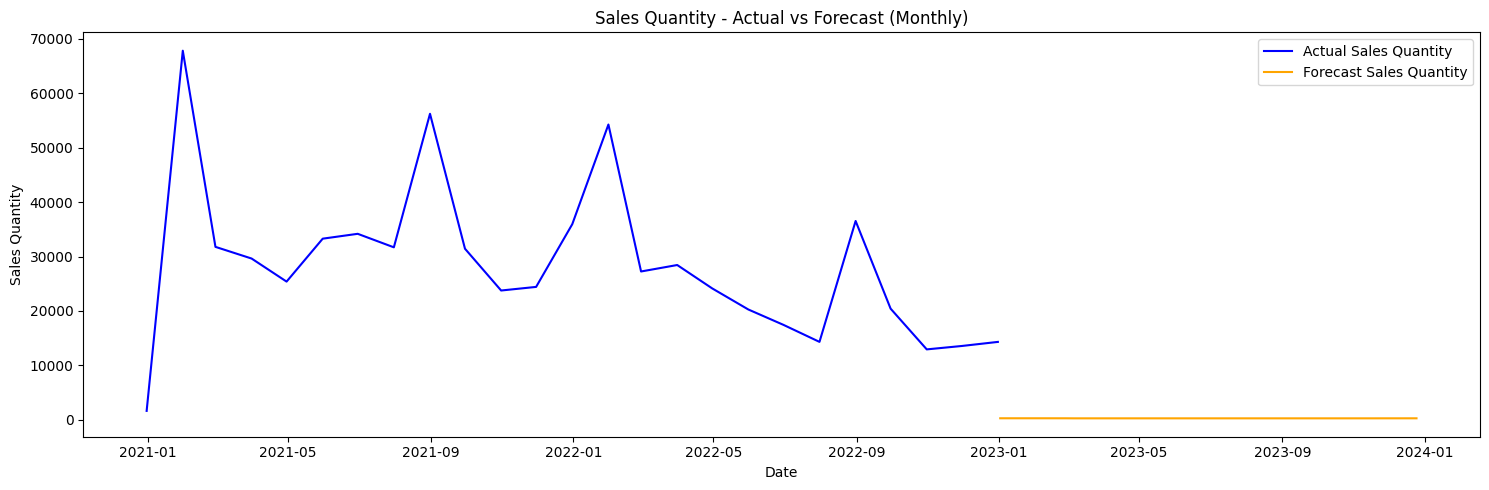

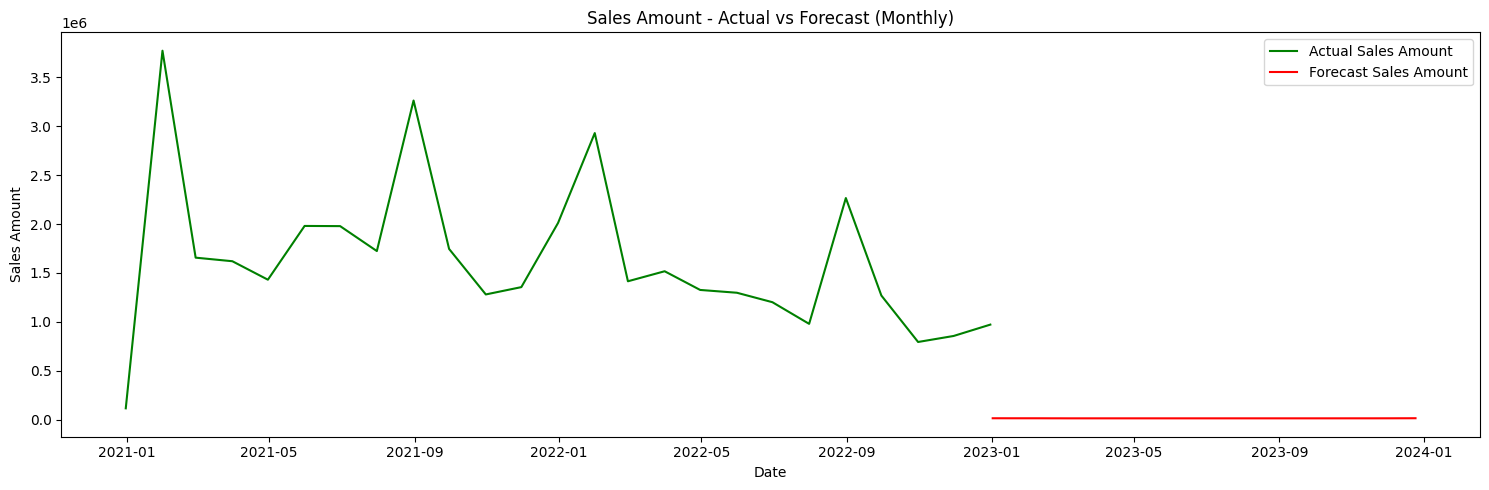

In [683]:
import pandas as pd
import matplotlib.pyplot as plt
model_df['Order Date'] = pd.to_datetime(model_df['Order Date'])
forecast_df['Order Date'] = pd.to_datetime(forecast_df['Order Date'])
monthly_actual = model_df.resample('M', on='Order Date').sum().reset_index()

monthly_forecast = forecast_df.reset_index()
combined_df = pd.concat([
    monthly_actual[['Order Date','Sales Quantity','Sales Amount']],
    monthly_forecast[['Order Date','Sales Quantity','Sales Amount']]
], ignore_index=True)

plt.figure(figsize=(15,5))
plt.plot(monthly_actual['Order Date'], monthly_actual['Sales Quantity'], label='Actual Sales Quantity', color='blue')
plt.plot(monthly_forecast['Order Date'], monthly_forecast['Sales Quantity'], label='Forecast Sales Quantity', color='orange')
plt.title('Sales Quantity - Actual vs Forecast (Monthly)')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(monthly_actual['Order Date'], monthly_actual['Sales Amount'], label='Actual Sales Amount', color='green')
plt.plot(monthly_forecast['Order Date'], monthly_forecast['Sales Amount'], label='Forecast Sales Amount', color='red')
plt.title('Sales Amount - Actual vs Forecast (Monthly)')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.tight_layout()
plt.show()


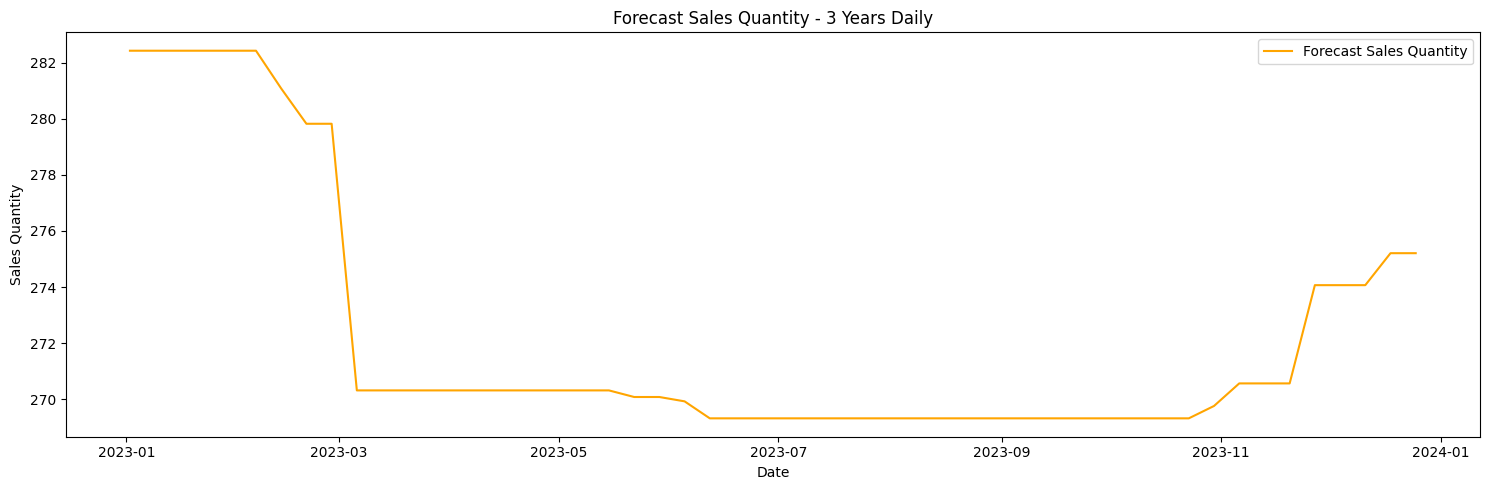

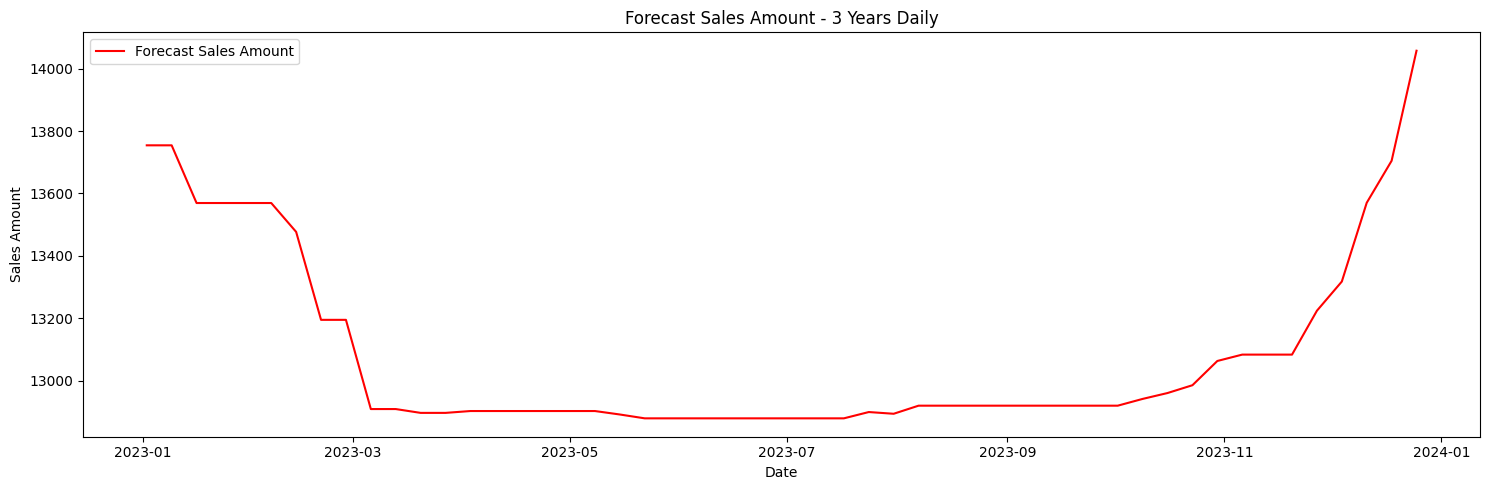

In [684]:
import matplotlib.pyplot as plt

# Plot Sales Quantity forecast
plt.figure(figsize=(15,5))
plt.plot(forecast_df['Order Date'], forecast_df['Sales Quantity'], label='Forecast Sales Quantity', color='orange')
plt.title('Forecast Sales Quantity - 3 Years Daily')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Sales Amount forecast
plt.figure(figsize=(15,5))
plt.plot(forecast_df['Order Date'], forecast_df['Sales Amount'], label='Forecast Sales Amount', color='red')
plt.title('Forecast Sales Amount - 3 Years Daily')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.tight_layout()
plt.show()


## <left><div style="font-family: Trebuchet MS; background-color: #F5C6EC; color: #2D2926; padding: 12px; line-height: 1;">Prophet</div></left>

In [857]:
from prophet import Prophet
from prophet.plot import plot_plotly

**Sales Quantity**

In [858]:
fc = df1.copy()
fc = fc[['Order Date','Sales Quantity']]
fc = fc.set_index('Order Date')
fc = pd.DataFrame(fc.resample('W-MON')[['Sales Quantity']].sum().round(2))

In [859]:
fc.head()

,Sales Quantity
Order Date,
2020-01-06,12898
2020-01-13,23797
2020-01-20,24499
2020-01-27,21976
2020-02-03,15315


In [860]:
train_data = fc.copy()

In [861]:
train_data = train_data.reset_index()
train_data.columns = ['ds', 'y']
train_data

,ds,y
0,2020-01-06,12898
1,2020-01-13,23797
2,2020-01-20,24499
3,2020-01-27,21976
4,2020-02-03,15315
...,...,...
152,2022-12-05,3009
153,2022-12-12,3307
154,2022-12-19,3475
155,2022-12-26,2567


In [862]:
holidays = pd.DataFrame({
  'holiday': df_holidays['Holiday'],
  'ds': pd.to_datetime(df_holidays['Date']),
  'lower_window': 0,
  'upper_window': 1,
})

In [863]:
from prophet import Prophet
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='additive' , holidays=holidays)
m.add_seasonality(name='monthly', period=4, fourier_order=3)
new_model = m.fit(train_data)

09:43:40 - cmdstanpy - INFO - Chain [1] start processing
09:43:40 - cmdstanpy - INFO - Chain [1] done processing


In [864]:
future_data = new_model.make_future_dataframe(periods=156, freq='w-mon')
predict = new_model.predict(future_data)
predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-06,12527.407389,11399.939738,17855.442105,12527.407389,12527.407389,0.0,0.0,0.0,0.0,...,-1069.296419,-1069.296419,-1069.296419,3745.928885,3745.928885,3745.928885,0.0,0.0,0.0,14766.641828
1,2020-01-13,12483.279609,16376.631969,22540.717371,12483.279609,12483.279609,0.0,0.0,0.0,0.0,...,-1069.296419,-1069.296419,-1069.296419,7843.649776,7843.649776,7843.649776,0.0,0.0,0.0,19560.831423
2,2020-01-20,12439.151829,17734.741009,23716.866867,12439.151829,12439.151829,0.0,0.0,0.0,0.0,...,-1069.296419,-1069.296419,-1069.296419,9790.524319,9790.524319,9790.524319,0.0,0.0,0.0,20635.861005
3,2020-01-27,12395.024049,16097.246313,22560.036586,12395.024049,12395.024049,0.0,0.0,0.0,0.0,...,-1069.296419,-1069.296419,-1069.296419,7951.183460,7951.183460,7951.183460,0.0,0.0,0.0,19143.583556
4,2020-02-03,12350.896270,11340.148318,17874.396607,12350.896270,12350.896270,0.0,0.0,0.0,0.0,...,-1069.296419,-1069.296419,-1069.296419,3635.162719,3635.162719,3635.162719,0.0,0.0,0.0,14479.364544


In [865]:
from prophet.plot import plot_plotly
plot_plotly(new_model, predict)

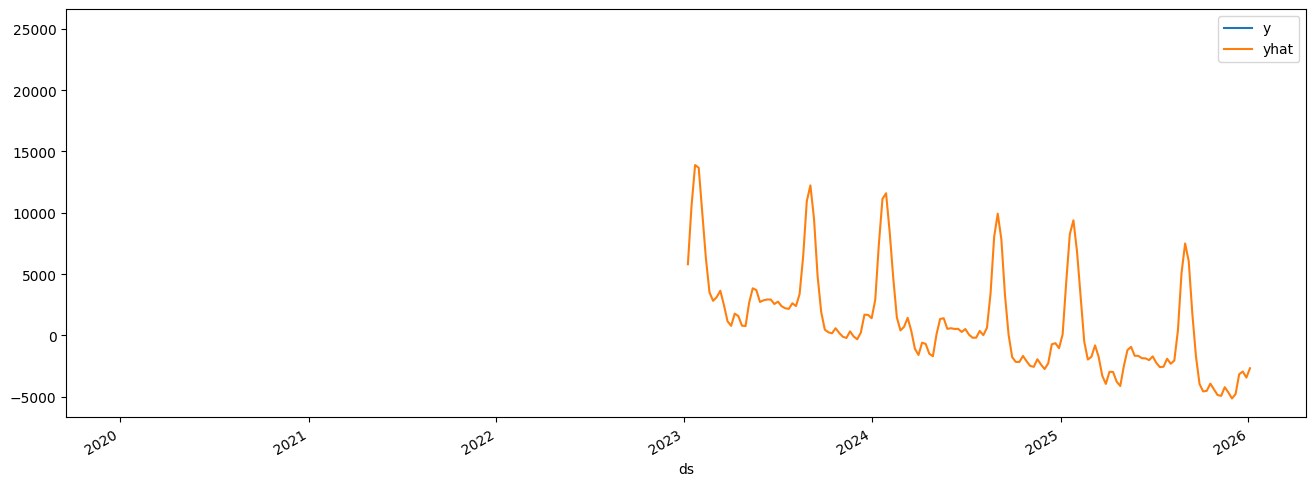

In [867]:
result = pd.concat([train_data1['y'], predict1['yhat']], axis=1)

result.plot(figsize= (16, 6))
plt.show()

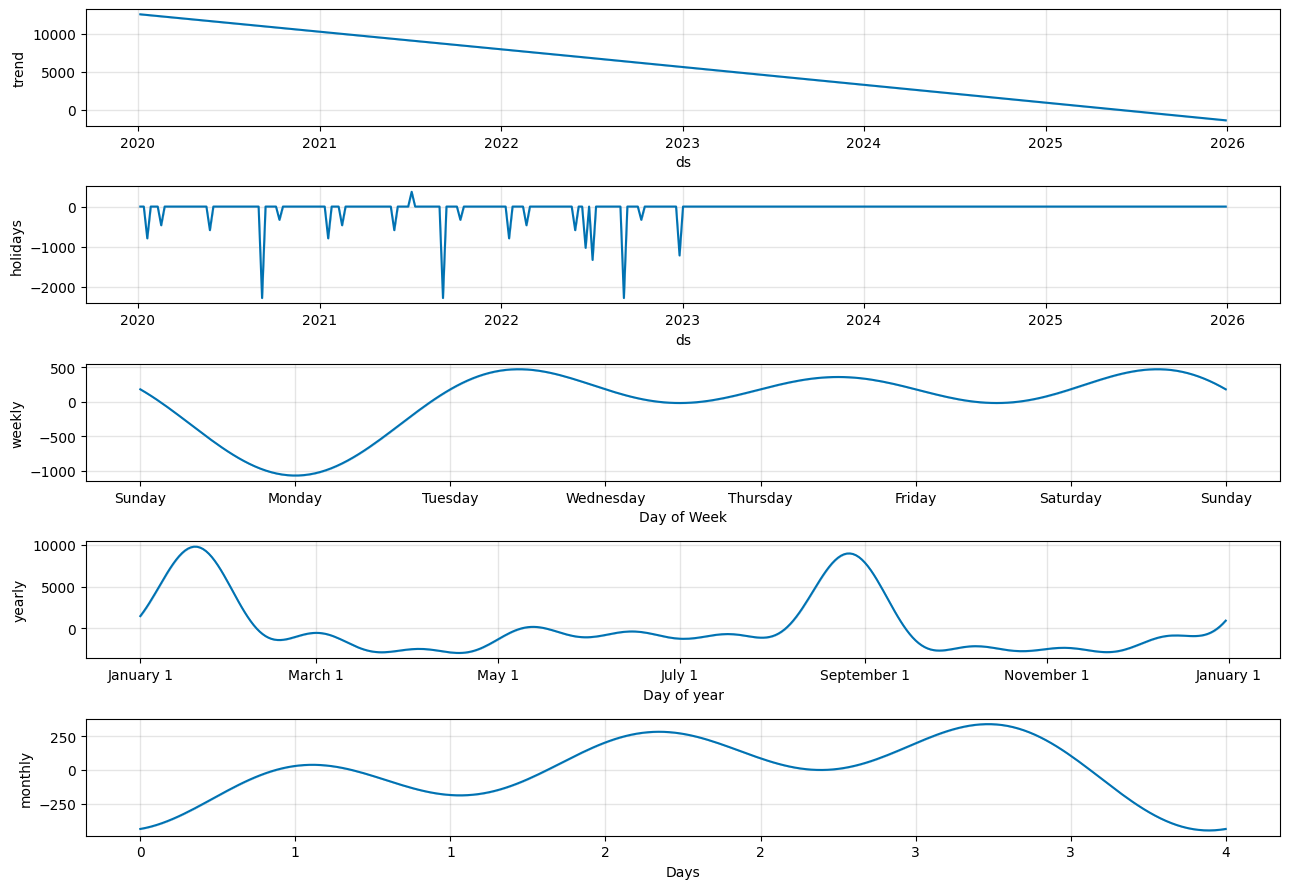

In [868]:
new_model.plot_components(predict, figsize=(13, 9));

**Sales Amount**

In [800]:
fc = df1.copy()
fc = fc[['Order Date','Sales Amount']]
fc = fc.set_index('Order Date')
fc = pd.DataFrame(fc.resample('W-MON')[['Sales Amount']].sum().round(2))

In [801]:
fc.head()

,Sales Amount
Order Date,
2020-01-06,669762.70
2020-01-13,1203497.89
2020-01-20,1232005.07
2020-01-27,1067802.92
2020-02-03,710312.51


In [802]:
train_data = fc.copy()

In [803]:
train_data = train_data.reset_index()
train_data.columns = ['ds', 'y']
train_data

,ds,y
0,2020-01-06,669762.70
1,2020-01-13,1203497.89
2,2020-01-20,1232005.07
3,2020-01-27,1067802.92
4,2020-02-03,710312.51
...,...,...
152,2022-12-05,199758.06
153,2022-12-12,228138.98
154,2022-12-19,224141.04
155,2022-12-26,171741.99


In [818]:
from prophet import Prophet
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='additive' , holidays=holidays)
#m.add_seasonality(name='monthly', period=4, fourier_order=3)
new_model = m.fit(train_data)

09:37:14 - cmdstanpy - INFO - Chain [1] start processing
09:37:15 - cmdstanpy - INFO - Chain [1] done processing


In [819]:
future_data = new_model.make_future_dataframe(periods=156, freq='w-mon')
predict = new_model.predict(future_data)
predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-06,654127.562063,634212.575777,9.870692e+05,654127.562063,654127.562063,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,202158.187917,202158.187917,202158.187917,0.0,0.0,0.0,8.113847e+05
1,2020-01-13,652086.876957,844073.528466,1.187982e+06,652086.876957,652086.876957,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,406164.668681,406164.668681,406164.668681,0.0,0.0,0.0,1.013350e+06
2,2020-01-20,650046.191851,895020.898295,1.251163e+06,650046.191851,650046.191851,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,492620.111231,492620.111231,492620.111231,0.0,0.0,0.0,1.076928e+06
3,2020-01-27,648005.506745,808398.934357,1.168923e+06,648005.506745,648005.506745,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,378419.428009,378419.428009,378419.428009,0.0,0.0,0.0,9.815239e+05
4,2020-02-03,645964.821639,561288.726792,9.139653e+05,645964.821639,645964.821639,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,137510.517057,137510.517057,137510.517057,0.0,0.0,0.0,7.385743e+05


In [820]:
from prophet.plot import plot_plotly
plot_plotly(new_model, predict)

In [821]:
train_data1 = train_data.copy()
train_data1 = train_data1.set_index('ds')
train_data1 = pd.DataFrame(train_data1.resample('w-mon').sum()['y'])
predict1 = predict.copy()
predict1 = predict1.set_index('ds')
predict1 = pd.DataFrame(predict1.resample('w-mon').sum()['yhat'])

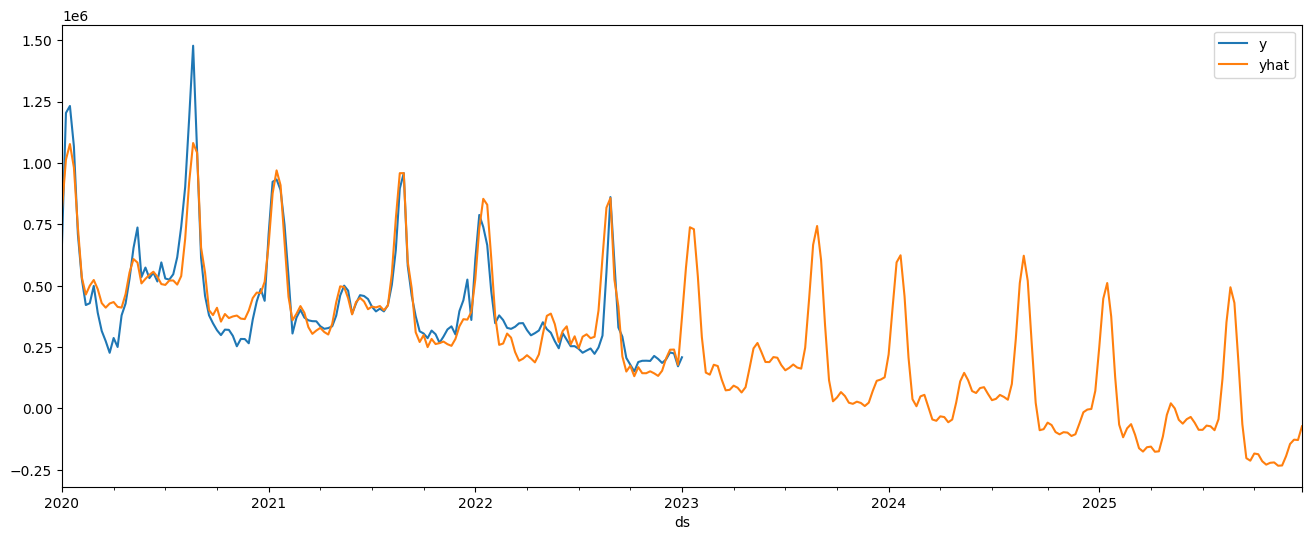

In [822]:
result = pd.concat([train_data1['y'], predict1['yhat']], axis=1)

result.plot(figsize= (16, 6))
plt.show()

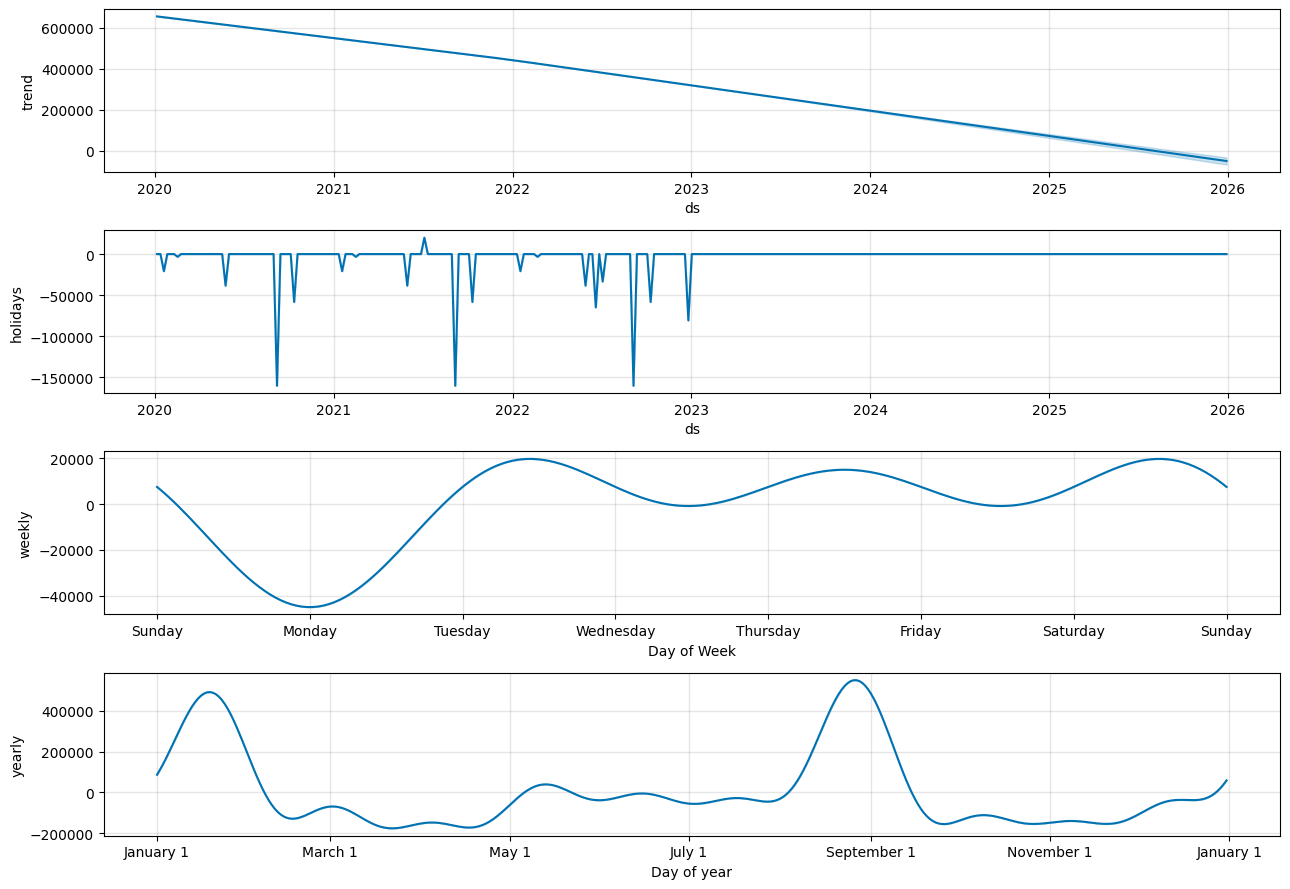

In [823]:
new_model.plot_components(predict, figsize=(13, 9));

In [825]:
eval = y.copy()

In [826]:
tts = int(len(y) * 0.8)

train = y[:tts]
test = y[tts:]


In [827]:
future_data = new_model.make_future_dataframe(periods=156, freq='w-mon')
predict = new_model.predict(future_data)
predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-06,654127.562063,633329.301424,9.876418e+05,654127.562063,654127.562063,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,202158.187917,202158.187917,202158.187917,0.0,0.0,0.0,8.113847e+05
1,2020-01-13,652086.876957,830349.496813,1.194078e+06,652086.876957,652086.876957,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,406164.668681,406164.668681,406164.668681,0.0,0.0,0.0,1.013350e+06
2,2020-01-20,650046.191851,891426.520319,1.255309e+06,650046.191851,650046.191851,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,492620.111231,492620.111231,492620.111231,0.0,0.0,0.0,1.076928e+06
3,2020-01-27,648005.506745,804482.005227,1.137808e+06,648005.506745,648005.506745,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,378419.428009,378419.428009,378419.428009,0.0,0.0,0.0,9.815239e+05
4,2020-02-03,645964.821639,569165.322386,9.068937e+05,645964.821639,645964.821639,0.0,0.0,0.0,0.0,...,-44901.067195,-44901.067195,-44901.067195,137510.517057,137510.517057,137510.517057,0.0,0.0,0.0,7.385743e+05


In [828]:
from prophet.plot import plot_plotly
plot_plotly(new_model, predict)

In [829]:
train_data1 = train_data.copy()
train_data1 = train_data1.set_index('ds')
train_data1 = pd.DataFrame(train_data1.resample('w-mon').sum()['y'])
predict1 = predict.copy()
predict1 = predict1.set_index('ds')
predict1 = pd.DataFrame(predict1.resample('w-mon').sum()['yhat'])

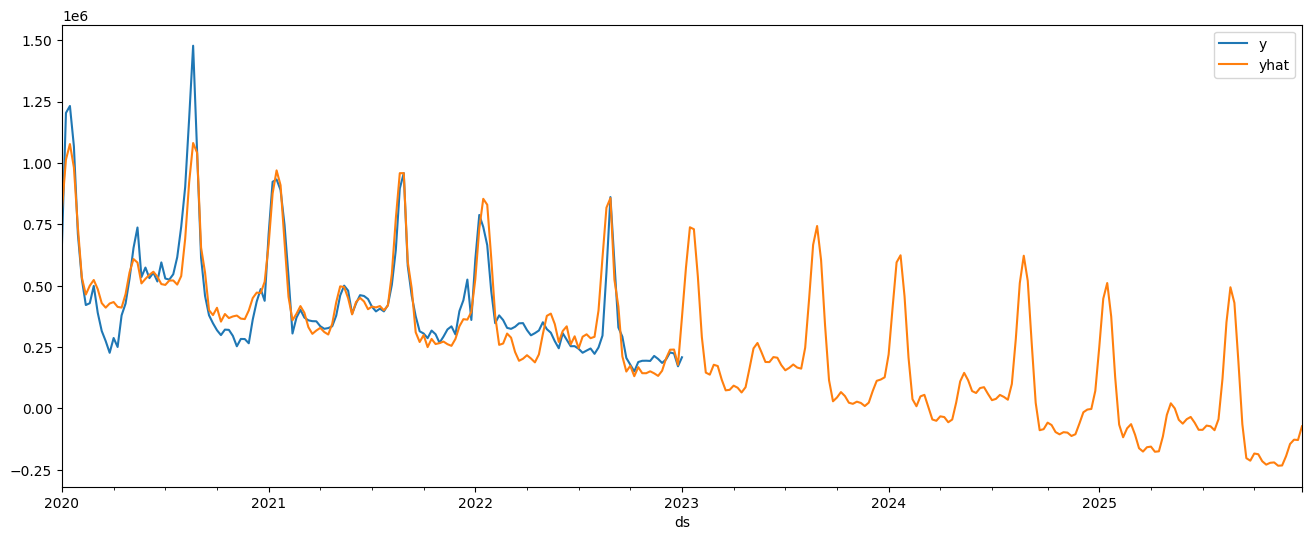

In [830]:
result = pd.concat([train_data1['y'], predict1['yhat']], axis=1)

result.plot(figsize= (16, 6))
plt.show()

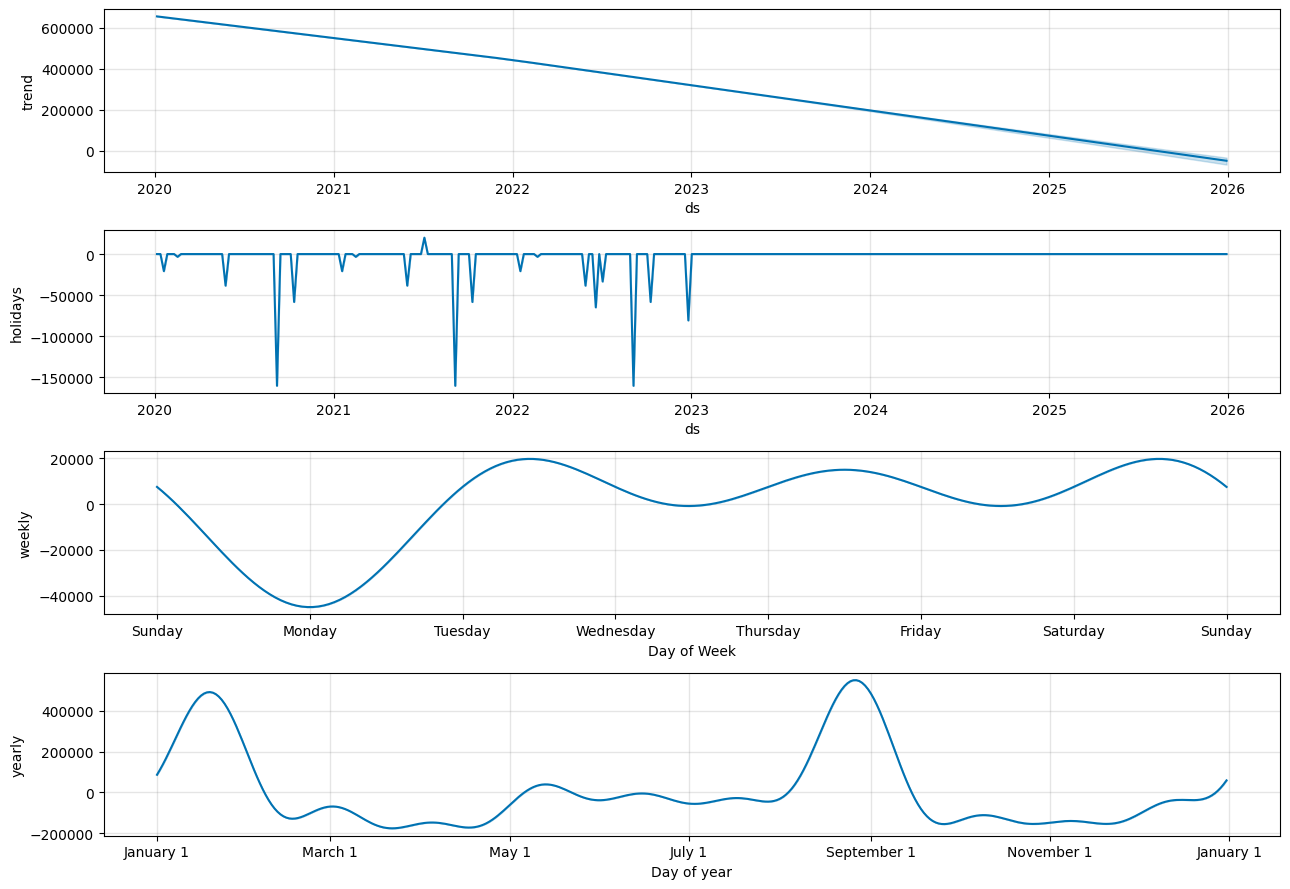

In [831]:
new_model.plot_components(predict, figsize=(13, 9));

# EVALUATION

**Amount**

In [876]:
fc = df1.copy()
fc = fc[['Order Date','Sales Amount']]
fc = fc.set_index('Order Date')
fc = pd.DataFrame(fc.resample('w')[['Sales Amount']].sum().round(2))

In [877]:
fc = fc.reset_index()
fc.columns = ['ds', 'y']

In [878]:
tts = int(len(fc)*0.8)
train_data = fc.iloc[:tts]
test_data = fc.iloc[tts:]
print(f"Number of weeks in train data: {len(train_data)}")
print(f"Number of weeks in test data: {len(test_data)}")

Number of weeks in train data: 125
Number of weeks in test data: 32


In [879]:
from prophet import Prophet
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='additive', holidays=holidays)
new_model = m.fit(train_data)

09:56:07 - cmdstanpy - INFO - Chain [1] start processing
09:56:07 - cmdstanpy - INFO - Chain [1] done processing


In [880]:
forecast_test = m.predict(test_data[['ds']])

In [881]:
test_eval0 = test_data.copy()
test_eval0['yhat'] = forecast_test['yhat'].values

In [883]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_eval0['y']
y_pred = test_eval0['yhat']

mae_amt_prophet = mean_absolute_error(y_true, y_pred)
rmse_amt_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mape_amt_prophet = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE  : {mae_amt_prophet:,.2f}")
print(f"RMSE : {rmse_amt_prophet:,.2f}")
print(f"MAPE : {mape_amt_prophet:.2f}%")


MAE  : 107,913.27
RMSE : 153,357.59
MAPE : 40.64%


**Quantity**

In [884]:
fc = df1.copy()
fc = fc[['Order Date','Sales Quantity']]
fc = fc.set_index('Order Date')
fc = pd.DataFrame(fc.resample('w')[['Sales Quantity']].sum().round(2))

In [885]:
fc = fc.reset_index()
fc.columns = ['ds', 'y']

In [886]:
tts = int(len(fc)*0.8)
train_data = fc.iloc[:tts]
test_data = fc.iloc[tts:]
print(f"Number of weeks in train data: {len(train_data)}")
print(f"Number of weeks in test data: {len(test_data)}")

Number of weeks in train data: 125
Number of weeks in test data: 32


In [887]:
from prophet import Prophet
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,seasonality_mode='additive', holidays=holidays)
new_model = m.fit(train_data)

09:56:48 - cmdstanpy - INFO - Chain [1] start processing
09:56:48 - cmdstanpy - INFO - Chain [1] done processing


In [888]:
forecast_test = m.predict(test_data[['ds']])

In [889]:
test_eval1 = test_data.copy()
test_eval1['yhat'] = forecast_test['yhat'].values

In [891]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_eval1['y']
y_pred = test_eval1['yhat']

mae_qty_prophet  = mean_absolute_error(y_true, y_pred)
rmse_qty_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mape_qty_prophet = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE  : {mae_qty_prophet:,.2f}")
print(f"RMSE : {rmse_qty_prophet:,.2f}")
print(f"MAPE : {mape_qty_prophet:.2f}%")


MAE  : 2,111.83
RMSE : 2,897.29
MAPE : 53.82%


## <left><div style="font-family: Trebuchet MS; background-color: #F5C6EC; color: #2D2926; padding: 12px; line-height: 1;">RNN</div></left>

In [1044]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [1045]:
df_qty= df.sort_values('Order Date')
df_qty = df_qty[['Order Date', 'Sales Quantity']]


In [1046]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_qty[['Sales Quantity']])

In [1047]:
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

LOOKBACK = 30
X, y = create_sequences(scaled_data, LOOKBACK)

In [1048]:
X.shape 

(2162, 30, 1)

In [1049]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [1050]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)


In [1051]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
55/55 [==============================] - 42s 295ms/step - loss: 0.0099 - val_loss: 0.0030
Epoch 2/100
55/55 [==============================] - 3s 62ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 3/100
55/55 [==============================] - 4s 67ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 4/100
55/55 [==============================] - 3s 61ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 5/100
55/55 [==============================] - 4s 72ms/step - loss: 0.0074 - val_loss: 0.0024
Epoch 6/100
55/55 [==============================] - 2s 44ms/step - loss: 0.0074 - val_loss: 0.0024
Epoch 7/100
55/55 [==============================] - 3s 52ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 8/100
55/55 [==============================] - 3s 46ms/step - loss: 0.0086 - val_loss: 0.0025
Epoch 9/100
55/55 [==============================] - 2s 44ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 10/100
55/55 [==============================] - 3s 55ms/step - loss: 0.0065 - val_loss: 0.00

In [1052]:
n_future = 30

last_window = scaled_data[-LOOKBACK:]
current_batch = last_window.reshape((1, LOOKBACK, 1))

future_preds = []

for i in range(n_future):
    pred = model.predict(current_batch, verbose=0)[0]
    future_preds.append(pred)
    current_batch = np.append(
        current_batch[:, 1:, :],
        [[pred]],
        axis=1
    )


In [1053]:
future_preds = scaler.inverse_transform(future_preds)

In [1054]:
last_date = df['Order Date'].iloc[-1]

future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=len(future_preds),
    freq='D'
)

forecast_df = pd.DataFrame({
    'Order Date': future_dates,
    'forecast_sales_qty': future_preds.flatten()
})


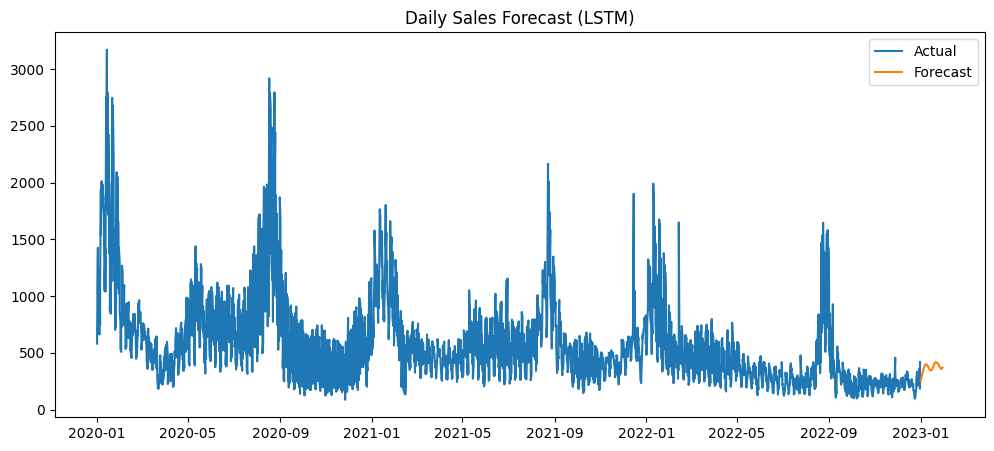

In [1055]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_qty['Order Date'], df_qty['Sales Quantity'], label='Actual')
plt.plot(forecast_df['Order Date'], forecast_df['forecast_sales_qty'], 
         label='Forecast')
plt.legend()
plt.title('Daily Sales Forecast (LSTM)')
plt.show()


In [1057]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

mae_try1 = mean_absolute_error(y_test_inv, y_pred_test)
rmse_try1 = np.sqrt(mean_squared_error(y_test_inv, y_pred_test))
mape_try1 = np.mean(np.abs((y_test_inv - y_pred_test) / y_test_inv)) * 100

print('MAE:', mae_try1)
print('RMSE:', rmse_try1)
print('MAPE:', mape_try1)


14/14 [==============================] - 1s 30ms/step
MAE: 78.88033879656714
RMSE: 128.81844665950842
MAPE: 27.672379547142818


### Sales Quantity

In [ ]:
WINDOW = 3

full_scaled = scaler.fit_transform(df_m[features])

X_all_q, y_all_q = create_sequences(full_scaled, WINDOW, target_idx=0)

In [ ]:
test_size = 6

X_train_q = X_all_q[:-test_size]
y_train_q = y_all_q[:-test_size]

X_test_q  = X_all_q[-test_size:]
y_test_q  = y_all_q[-test_size:]

In [ ]:
model_q = Sequential([
    LSTM(32, return_sequences=True, input_shape=(WINDOW, X_train_q.shape[2])),
    Dropout(0.2),
    LSTM(16),
    Dense(1)
])

model_q.compile(optimizer='adam', loss='mse')
model_q.fit(X_train_q, y_train_q, epochs=60, batch_size=4, verbose=1)


Epoch 1/60
7/7 [==============================] - 7s 16ms/step - loss: 0.1392
Epoch 2/60
7/7 [==============================] - 0s 14ms/step - loss: 0.0958
Epoch 3/60
7/7 [==============================] - 0s 38ms/step - loss: 0.0680
Epoch 4/60
7/7 [==============================] - 0s 47ms/step - loss: 0.0447
Epoch 5/60
7/7 [==============================] - 0s 32ms/step - loss: 0.0404
Epoch 6/60
7/7 [==============================] - 0s 11ms/step - loss: 0.0428
Epoch 7/60
7/7 [==============================] - 0s 17ms/step - loss: 0.0414
Epoch 8/60
7/7 [==============================] - 0s 11ms/step - loss: 0.0413
Epoch 9/60
7/7 [==============================] - 0s 10ms/step - loss: 0.0398
Epoch 10/60
7/7 [==============================] - 0s 11ms/step - loss: 0.0376
Epoch 11/60
7/7 [==============================] - 0s 12ms/step - loss: 0.0382
Epoch 12/60
7/7 [==============================] - 0s 21ms/step - loss: 0.0385
Epoch 13/60
7/7 [==============================] - 0s 20ms/st

### Sales Amount

In [ ]:
X_train_a, y_train_a = create_sequences(train_scaled, WINDOW, 1)
X_test_a,  y_test_a  = create_sequences(test_scaled,  WINDOW, 1)

In [ ]:
model_a = Sequential([
    LSTM(32, return_sequences=True, input_shape=(WINDOW, X_train_a.shape[2])),
    Dropout(0.2),
    LSTM(16),
    Dense(1)
])

model_a.compile(optimizer='adam', loss='mse')
model_a.fit(X_train_a, y_train_a, epochs=60, batch_size=4, verbose=1)


Epoch 1/60
7/7 [==============================] - 7s 6ms/step - loss: 0.1107
Epoch 2/60
7/7 [==============================] - 0s 6ms/step - loss: 0.0796
Epoch 3/60
7/7 [==============================] - 0s 6ms/step - loss: 0.0660
Epoch 4/60
7/7 [==============================] - 0s 6ms/step - loss: 0.0569
Epoch 5/60
7/7 [==============================] - 0s 6ms/step - loss: 0.0589
Epoch 6/60
7/7 [==============================] - 0s 7ms/step - loss: 0.0577
Epoch 7/60
7/7 [==============================] - 0s 6ms/step - loss: 0.0594
Epoch 8/60
7/7 [==============================] - 0s 6ms/step - loss: 0.0569
Epoch 9/60
7/7 [==============================] - 0s 7ms/step - loss: 0.0559
Epoch 10/60
7/7 [==============================] - 0s 19ms/step - loss: 0.0539
Epoch 11/60
7/7 [==============================] - 0s 9ms/step - loss: 0.0540
Epoch 12/60
7/7 [==============================] - 0s 8ms/step - loss: 0.0549
Epoch 13/60
7/7 [==============================] - 0s 8ms/step - loss: 0

In [ ]:
print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("X_train_q :", X_train_q.shape)
print("X_test_q  :", X_test_q.shape)


Train shape: (30, 6)
Test shape : (6, 6)
X_train_q : (27, 3, 4)
X_test_q  : (6, 3, 4)


In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def inverse_target(pred, idx):
    dummy = np.zeros((len(pred), len(features)))
    dummy[:, idx] = pred.flatten()
    return scaler.inverse_transform(dummy)[:, idx]

# Quantity
pred_q = model_q.predict(X_test_q)
y_q_true = inverse_target(y_test_q.reshape(-1,1), 0)
y_q_pred = inverse_target(pred_q, 0)

# Amount
pred_a = model_a.predict(X_test_a)
y_a_true = inverse_target(y_test_a.reshape(-1,1), 1)
y_a_pred = inverse_target(pred_a, 1)

print("MAE Quantity:", mean_absolute_error(y_q_true, y_q_pred))
print("MAE Amount  :", mean_absolute_error(y_a_true, y_a_pred))




1/1 [==============================] - 1s 1s/step
MAE Quantity: 19716.327907840412
MAE Amount  : 1526300.207843987


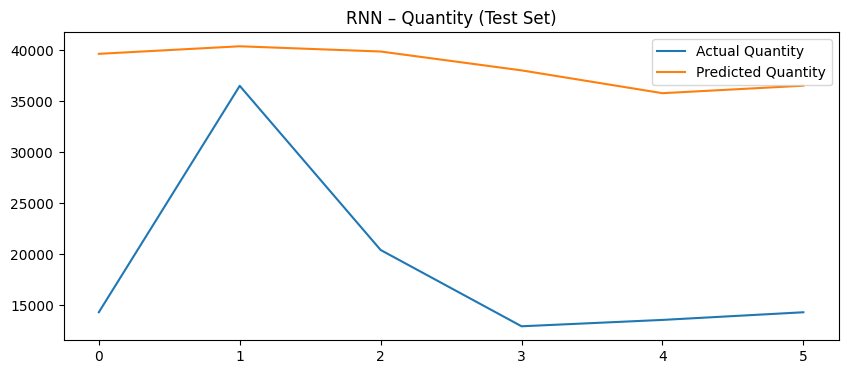

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_q_true, label='Actual Quantity')
plt.plot(y_q_pred, label='Predicted Quantity')
plt.title('RNN – Quantity (Test Set)')
plt.legend()
plt.show()


# TRY

In [432]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df_m = (
    df
    .set_index('Order Date')
    .resample('D')
    .agg({
        'Sales Quantity': 'sum',
        'Sales Amount': 'sum'
    })
    .reset_index()
)

df_m.head()

,Order Date,Sales Quantity,Sales Amount
0,2020-01-01,1272,68654.82
1,2020-01-02,2440,123634.13
2,2020-01-03,2232,116255.66
3,2020-01-04,1589,81867.06
4,2020-01-05,1883,97488.79


In [368]:
len(df_m)

1096

<Axes: title={'center': 'Daily Sales Quantity Over Time'}, xlabel='Order Date'>

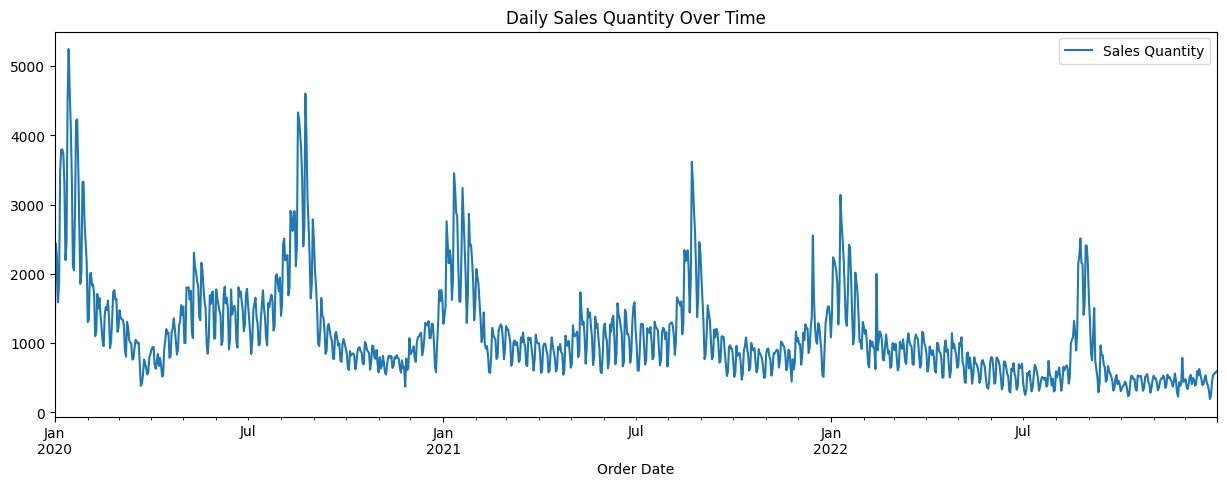

In [472]:
df_m.plot(x='Order Date', y='Sales Quantity', figsize=(15,5), title='Daily Sales Quantity Over Time')

Quantity

In [1058]:
df_m = df_m[['Order Date','Sales Quantity']]

In [1059]:
tts = int(len(df_m)*0.8)
train = df_m.iloc[:tts]
test = df_m.iloc[tts:]
print(f"Number train data: {len(train)}")
print(f"Number test data: {len(test)}")

Number train data: 876
Number test data: 220


In [1060]:
train.shape, test.shape

((876, 2), (220, 2))

--------

# Scale Data

In [1061]:
from sklearn.preprocessing import MinMaxScaler

In [1062]:
scaler = MinMaxScaler()

In [1063]:
train

,Order Date,Sales Quantity
0,2020-01-01,1272
1,2020-01-02,2440
2,2020-01-03,2232
3,2020-01-04,1589
4,2020-01-05,1883
...,...,...
871,2022-05-21,426
872,2022-05-22,473
873,2022-05-23,730
874,2022-05-24,757


In [1064]:
scaled_train = scaler.fit_transform(train[['Sales Quantity']])
scaled_test = scaler.transform(test[['Sales Quantity']])

-------

In [1065]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [1066]:
length = 12
batch_size = 32

generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,
                                               length=length, batch_size=batch_size)

In [1067]:
X, y = generator[0]

In [1068]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.18478261 0.42432322 0.3816653  0.24979491 0.31009024 0.63802297
 0.70159967 0.70303527 0.6892945  0.60151764 0.37510254 0.42719442
 0.42432322 0.3816653  0.24979491 0.31009024 0.63802297 0.70159967
 0.70303527 0.6892945  0.60151764 0.37510254 0.42719442 0.85008203
 0.3816653  0.24979491 0.31009024 0.63802297 0.70159967 0.70303527
 0.6892945  0.60151764 0.37510254 0.42719442 0.85008203 1.
 0.24979491 0.31009024 0.63802297 0.70159967 0.70303527 0.6892945
 0.60151764 0.37510254 0.42719442 0.85008203 1.         0.87387203
 0.31009024 0.63802297 0.70159967 0.70303527 0.6892945  0.60151764
 0.37510254 0.42719442 0.85008203 1.         0.87387203 0.77317473
 0.63802297 0.70159967 0.70303527 0.6892945  0.60151764 0.37510254
 0.42719442 0.85008203 1.         0.87387203 0.77317473 0.61607875
 0.70159967 0.70303527 0.6892945  0.60151764 0.37510254 0.42719442
 0.85008203 1.         0.87387203 0.77317473 0.61607875 0.35828548
 0.70303527 0.6892945  0.60151764 0.37510254 0.427194

---------

# Model Building

In [1069]:
n_features = 1

In [1070]:
model = Sequential([
    LSTM(70, input_shape=(length, n_features)),
    Dense(1, activation='relu')
])

model.compile(
    optimizer='adam',
    loss='mse'
)


In [1071]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 70)                20160     
                                                                 
 dense_3 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# EarlyStopping and creating a Validation Generator

In [1072]:
from tensorflow.keras.callbacks import EarlyStopping

In [1073]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [1074]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                                                      length=length, batch_size=batch_size)

# Fit the model

In [1075]:
model.fit(generator,
             validation_data = validation_generator,
             epochs=50,
             callbacks=[early_stopping],
             verbose=1)

Epoch 1/50
27/27 [==============================] - 11s 88ms/step - loss: 0.0512 - val_loss: 0.0093
Epoch 2/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0512 - val_loss: 0.0093
Epoch 3/50
27/27 [==============================] - 1s 45ms/step - loss: 0.0512 - val_loss: 0.0093
Epoch 4/50
27/27 [==============================] - 1s 18ms/step - loss: 0.0512 - val_loss: 0.0093
Epoch 4: early stopping


In [1076]:
losses = pd.DataFrame(model.history.history)

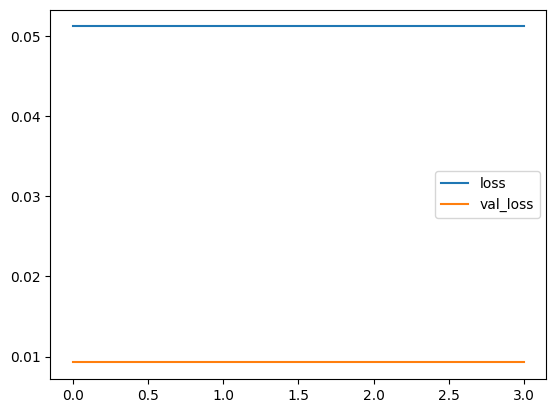

In [1077]:
losses.plot();

--------

# Evaluate on Test Data

In [1078]:
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 70)                20160     
                                                                 
 dense_3 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [1079]:
last_train_batch = scaled_train[-length:]
last_train_batch = last_train_batch.reshape((1, length, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 1s 1s/step


array([[0.]], dtype=float32)

In [1080]:
test_predictions = []

first_evaluation_batch = scaled_train[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

1/1 [==============================] - 0s 60ms/step


# Inverse Transformations and Compare

In [1081]:
true_predictions = scaler.inverse_transform(test_predictions)

In [1082]:
test['Predictions quatity'] = true_predictions

In [1083]:
test.sort_values('Order Date').head(20)

,Order Date,Sales Quantity,Predictions quatity
876,2022-05-26,651,371.0
877,2022-05-27,491,371.0
878,2022-05-28,366,371.0
879,2022-05-29,342,371.0
880,2022-05-30,432,371.0
881,2022-05-31,724,371.0
882,2022-06-01,799,371.0
883,2022-06-02,783,371.0
884,2022-06-03,634,371.0
885,2022-06-04,413,371.0


In [1087]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae_qty_lstm = mean_absolute_error(test['Sales Quantity'], test['Predictions quatity'])
print(f'Mean Absolute Error: {mae}')
rmse_qty_lstm = np.sqrt(mean_squared_error(test['Sales Quantity'], test['Predictions quatity']))
print(f'Root Mean Squared Error: {rmse}')
mape_qty_lstm = np.mean(np.abs((test['Sales Quantity'] - test['Predictions quatity']) / test['Sales Quantity'])) * 100
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Error: 252.80454545454546
Root Mean Squared Error: 460.2525245597642
Mean Absolute Percentage Error: 31.30934909208859%


In [1085]:
test.set_index('Order Date', inplace=True)

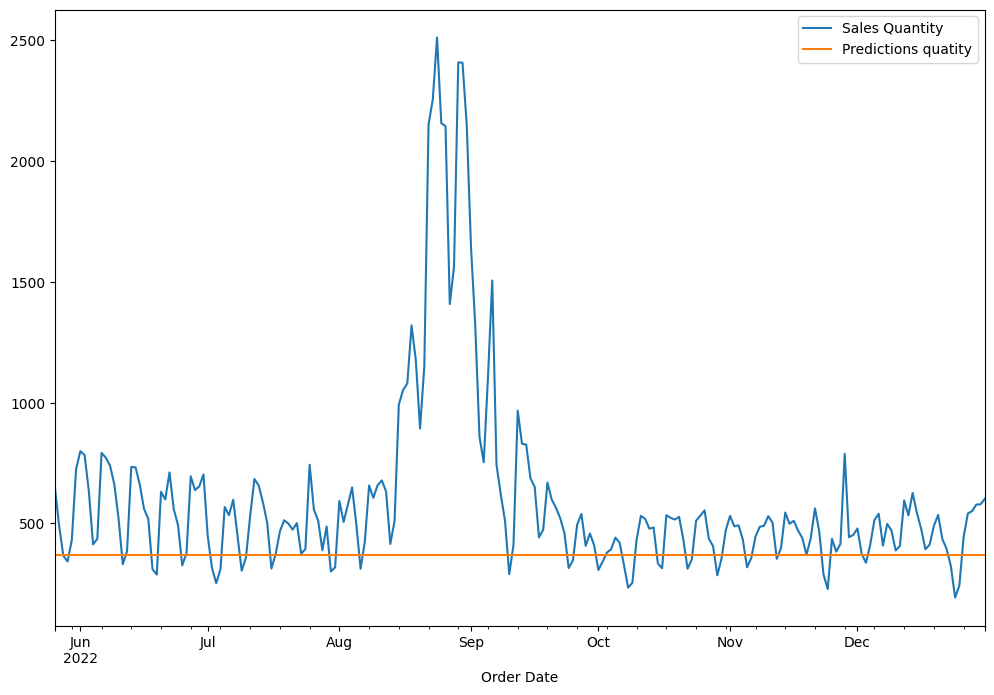

In [1086]:
test.plot(figsize=(12,8));

If we decide the above predictions values are good enough, we will proceed to forecast for unknown future.

-----
--------

# SARIMAX

Quantity

In [ ]:
import pandas as pd

df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values('Order Date')

qty = (
    df
    .set_index('Order Date')
    .resample('w')  # Month Start
    .sum()
    .reset_index()
)

qty.head()


,Order Date,Subject Category,Sales Amount,Sales Quantity
0,2020-01-05,Science & TechnologyMedicalMedicalScience & Te...,487900.46,9416
1,2020-01-12,MedicalScience & TechnologyMedicalScience & Te...,1154499.26,22763
2,2020-01-19,Science & TechnologyMedicalScience & Technolog...,1321315.56,26080
3,2020-01-26,Science & TechnologyMedicalScience & Technolog...,1049702.81,21591
4,2020-02-02,Science & TechnologyMedicalMedicalScience & Te...,776451.89,16637


In [10]:
qty = qty.set_index('Order Date')
y = qty['Sales Quantity']


In [11]:
order = (1, 1, 0)
seasonal_order = (0, 1, 1, 52)


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = model.fit(disp=False)
print(sarimax_result.summary())


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                       Sales Quantity   No. Observations:                  157
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 52)   Log Likelihood                -441.462
Date:                              Mon, 05 Jan 2026   AIC                            888.923
Time:                                      14:34:16   BIC                            894.719
Sample:                                  01-05-2020   HQIC                           891.138
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1577      0.126     -1.251      0.211      -0.405       0.089
ma.S.L52       0.16

In [13]:
forecast_steps = 3 * 52
forecast = sarimax_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(
    start=y.index[-1] + pd.Timedelta(weeks=1),
    periods=forecast_steps,
    freq='w'
)
forecast_df_qty = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)
#forecast_df['Lower CI'] = forecast.conf_int()['lower Sales']
#forecast_df['Upper CI'] = forecast.conf_int()['upper Sales']

In [14]:
#forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

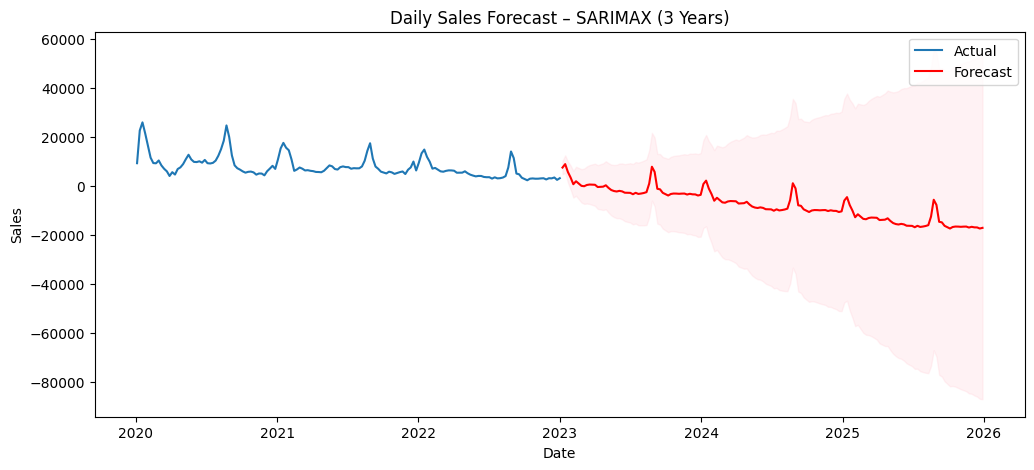

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(y, label='Actual')
plt.plot(forecast_df_qty['Forecast'], label='Forecast', color='red')
plt.fill_between(
    forecast_df_qty.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink', alpha=0.2
)
plt.legend()
plt.title('Daily Sales Forecast – SARIMAX (3 Years)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [17]:
eval = y.copy()

In [18]:
tts = int(len(y) * 0.8)

train = y[:tts]
test = y[tts:]


In [19]:
model_bt = SARIMAX(
    train,
    order=(1,1,0),
    seasonal_order=(0,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result_bt = model_bt.fit(disp=False)


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
pred = result_bt.get_forecast(steps=32)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = pred.predicted_mean
conf_int = pred.conf_int()
mae_qty_sarimax = mean_absolute_error(test, y_pred)
rmse_qty_sarimax = np.sqrt(mean_squared_error(test, y_pred))
mape_qty_sarimax =   mape(test, y_pred)

print(f"MAE  : {mae_qty_sarimax:,.0f}")
print(f"RMSE : {rmse_qty_sarimax:,.0f}")
print(f"MAPE : {mape_qty_sarimax:.2f}%")


MAE  : 1,483
RMSE : 1,962
MAPE : 35.68%


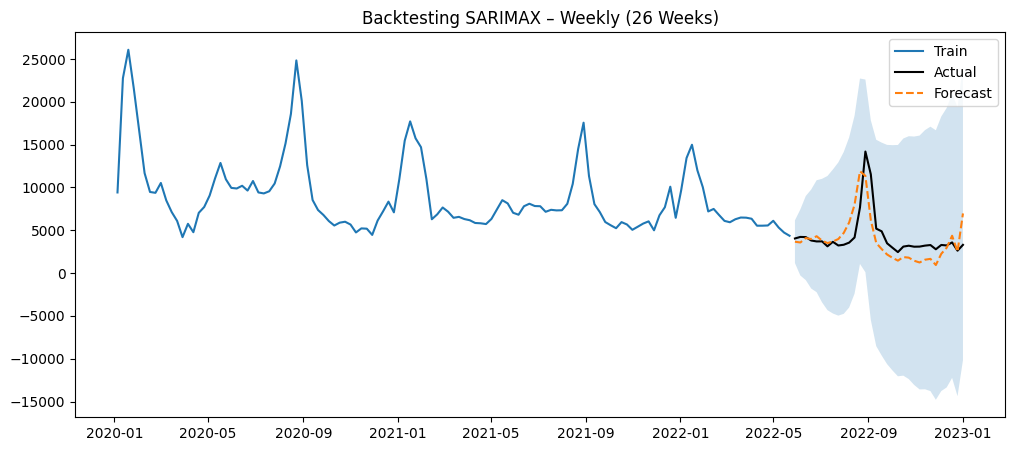

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(y_pred.index, y_pred, label='Forecast', linestyle='--')

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.2
)

plt.title('Backtesting SARIMAX – Weekly (26 Weeks)')
plt.legend()
plt.show()


Amount

In [23]:
import pandas as pd

df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values('Order Date')

amt = (
    df
    .set_index('Order Date')
    .resample('W')
    .sum()
    .reset_index()
)

amt.head()


,Order Date,Subject Category,Sales Amount,Sales Quantity
0,2020-01-05,Science & TechnologyMedicalMedicalScience & Te...,487900.46,9416
1,2020-01-12,MedicalScience & TechnologyMedicalScience & Te...,1154499.26,22763
2,2020-01-19,Science & TechnologyMedicalScience & Technolog...,1321315.56,26080
3,2020-01-26,Science & TechnologyMedicalScience & Technolog...,1049702.81,21591
4,2020-02-02,Science & TechnologyMedicalMedicalScience & Te...,776451.89,16637


In [24]:
len(amt)

157

In [25]:
amt = amt.set_index('Order Date')
y = amt['Sales Amount']


In [26]:
order = (1, 1, 0)
seasonal_order = (0, 1, 1, 52)

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = model.fit(disp=False)
print(sarimax_result.summary())


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                         Sales Amount   No. Observations:                  157
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 52)   Log Likelihood                -642.480
Date:                              Mon, 05 Jan 2026   AIC                           1290.960
Time:                                      14:51:48   BIC                           1296.755
Sample:                                  01-05-2020   HQIC                          1293.174
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1165      0.207     -0.564      0.573      -0.521       0.288
ma.S.L52       0.18

In [28]:
n_future = 3*52 

forecast = sarimax_result.get_forecast(steps=n_future)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [30]:
forecast_index = pd.date_range(
    start=y.index[-1] + pd.Timedelta(weeks=1),
    periods=forecast_steps,
    freq='w'
)
forecast_df_amt = pd.DataFrame({
    'Order Date': forecast_index,
    'forecast_sales_amt': forecast_mean.values
}).set_index('Order Date')


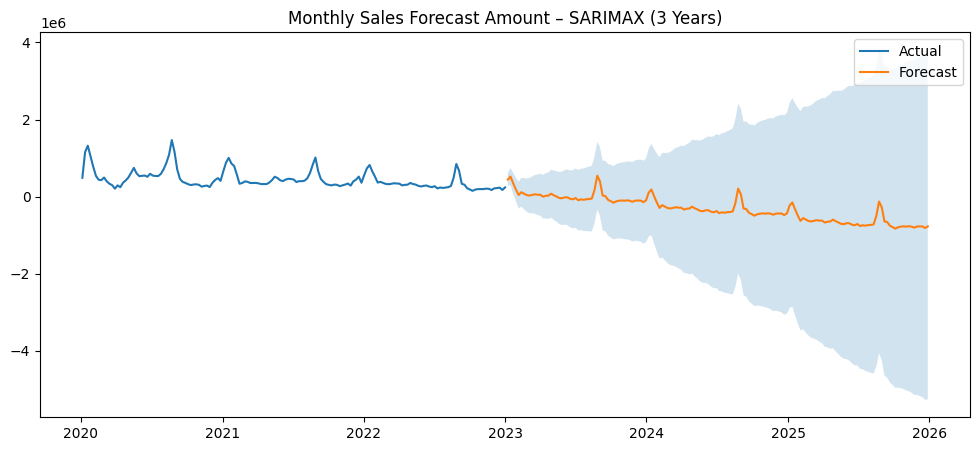

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y, label='Actual')
plt.plot(forecast_df_amt, label='Forecast')
plt.fill_between(
    forecast_df_amt.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2
)
plt.legend()
plt.title('Monthly Sales Forecast Amount – SARIMAX (3 Years)')
plt.show()

In [32]:
eval = y.copy()

In [33]:
tts = int(len(y) * 0.8)

train = y[:tts]
test = y[tts:]


In [34]:
model_bt = SARIMAX(
    train,
    order=(1,1,0),
    seasonal_order=(0,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result_bt = model_bt.fit(disp=False)


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [35]:
pred = result_bt.get_forecast(steps=32)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = pred.predicted_mean
conf_int = pred.conf_int()
mae_amt_sarimax = mean_absolute_error(test, y_pred)
rmse_amt_sarimax = np.sqrt(mean_squared_error(test, y_pred))
mape_amt_sarimax = mape(test, y_pred)


print(f"MAE  : {mae_amt_sarimax:,.0f}")
print(f"RMSE : {rmse_amt_sarimax:,.0f}")
print(f"MAPE : {mape_amt_sarimax:.2f}%")


MAE  : 58,465
RMSE : 102,009
MAPE : 18.23%


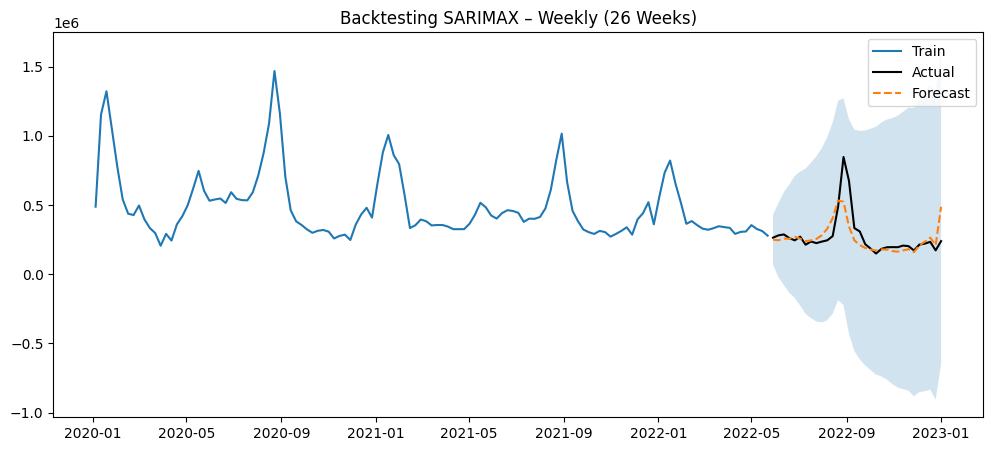

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(y_pred.index, y_pred, label='Forecast', linestyle='--')

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.2
)

plt.title('Backtesting SARIMAX – Weekly (26 Weeks)')
plt.legend()
plt.show()


In [37]:
forecast_df_amt

,forecast_sales_amt
Order Date,
2023-01-08,440563.329692
2023-01-15,520671.629832
2023-01-22,343687.501548
2023-01-29,182788.224692
2023-02-05,43193.516526
...,...
2025-11-30,-774581.923960
2025-12-07,-773075.300691
2025-12-14,-773276.084523


# <center><div style="font-family: Trebuchet MS; background-color: #57C5B6; color: #2D2926; padding: 12px; line-height: 1;">**SUMMARY**</div></center>

Perbandingan

In [ ]:

summary_data = [
    ['Random Forest', mae_qty_tuned, rmse_qty_tuned, mape_qty_tuned],
    ['Prophet', mae_qty_prophet, rmse_qty_prophet, mape_qty_prophet],
    ['LSTM', mae_qty_lstm, rmse_qty_lstm, mape_qty_lstm],
    ['SARIMAX', mae_qty_sarimax, rmse_qty_sarimax, mape_qty_sarimax]
]
Summary_qty = pd.DataFrame(summary_data, columns=['Model', 'MAE', 'RMSE', 'MAPE'])

def assign_status(model_name):
    if model_name in ['LSTM', 'Random Forest']:
        return 'Forecast Long Period/3 Years - Graphic prediction not applicable'
    else:
        return 'Applicable'

Summary_qty['Status'] = Summary_qty['Model'].apply(assign_status)

Summary_qty.set_index('Model', inplace=True)


summary_data_amt = [
    ['Random Forest', mae_amt_tuned, rmse_amt_tuned, mape_amt_tuned],
    ['Prophet', mae_amt_prophet, rmse_amt_prophet, mape_amt_prophet],
    ['SARIMAX', mae_amt_sarimax, rmse_amt_sarimax, mape_amt_sarimax]
]

Summary_amt = pd.DataFrame(summary_data_amt, columns=['Model', 'MAE', 'RMSE', 'MAPE'])
def assign_status_amt(model_name):
    if model_name in ['LSTM', 'Random Forest']:
        return 'Forecast Long Period/3 Years - Graphic prediction not applicable'
    else:
        return 'Applicable'
Summary_amt['Status'] = Summary_amt['Model'].apply(assign_status_amt)
Summary_amt.set_index('Model', inplace=True)

In [ ]:
Summary_qty

,MAE,RMSE,MAPE,Status
Model,,,,
Random Forest,90.423847,146.066166,32.199584,Forecast Long Period/3 Years - Graphic predict...
Prophet,2111.829141,2897.290640,53.818132,Applicable
LSTM,252.804545,460.252525,31.309349,Forecast Long Period/3 Years - Graphic predict...
SARIMAX,1483.007016,1961.523305,35.684483,Applicable


In [ ]:
Summary_amt

,MAE,RMSE,MAPE,Status
Model,,,,
Random Forest,5115.434337,7884.670591,29.299361,Forecast Long Period/3 Years - Graphic predict...
Prophet,107913.267490,153357.590165,40.641093,Applicable
SARIMAX,58465.365705,102009.390862,18.232356,Applicable


So i choose **SARIMAX Model**

In [38]:

Sarimax = forecast_df_amt.join(forecast_df_qty, how='inner')
Sarimax.reset_index(inplace=True)
Sarimax.rename(columns={
    'forecast_sales_amt': 'Sales Amount Forecast - SARIMAX',
    'Forecast': 'Sales Quantity Forecast - SARIMAX'
}, inplace=True)
Sarimax.head()


,Order Date,Sales Amount Forecast - SARIMAX,Sales Quantity Forecast - SARIMAX
0,2023-01-08,440563.329692,7637.026464
1,2023-01-15,520671.629832,9042.901811
2,2023-01-22,343687.501548,5811.590699
3,2023-01-29,182788.224692,3561.228662
4,2023-02-05,43193.516526,834.478092


In [39]:
Sarimax.to_excel('Forecasting Result-Sarimax.xlsx', index = False)

In [ ]:
df1.to_excel('Sales_Data_Full.xlsx', index=False)


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order Date        2192 non-null   datetime64[ns]
 1   Subject Category  2192 non-null   object        
 2   Sales Amount      2192 non-null   float64       
 3   Sales Quantity    2192 non-null   int64         
 4   isholiday         2192 non-null   int32         
 5   holiday_name      2192 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 94.3+ KB


## Connect PostgreeSQL

In [41]:
import tempfile
import psycopg2
import pandas as pd
from zipfile import ZipFile

def save_new_raw_data():
    local_path = r'C:\Users\user\Downloads\Test y ventures\data full.zip'

    with tempfile.TemporaryDirectory() as dirpath:
        with ZipFile(local_path, "r") as zipfile:
            target_file = [f for f in zipfile.namelist() if 'Sales_Data_Full.xlsx' in f]
            if not target_file:
                raise FileNotFoundError("File 'Sales_Data_Full.xlsx' tidak ditemukan dalam ZIP")
            excel_path = zipfile.extract(target_file[0], path=dirpath)
            df = pd.read_excel(excel_path)

    return df


def load_raw(data: pd.DataFrame, conn) -> None:
    cur = conn.cursor()
    cur.execute('DROP TABLE IF EXISTS sales_data;')

    cur.execute("""
    CREATE TABLE sales_data (
        id SERIAL PRIMARY KEY,
        order_date DATE NOT NULL,
        subject_category VARCHAR(100),
        sales_amount NUMERIC,
        sales_quantity INT,
        isholiday INT,
        holiday_name VARCHAR(100)
    );
    """)

    for _, row in data.iterrows():
        order_date = row['Order Date'].strftime('%d-%m-%Y') if not pd.isna(row['Order Date']) else '01-01-1970'
        subject_category = '' if pd.isna(row['Subject Category']) else str(row['Subject Category']).replace("'", "''")
        holiday_name = '' if pd.isna(row['holiday_name']) else str(row['holiday_name']).replace("'", "''")
        sales_amount = 0 if pd.isna(row['Sales Amount']) else row['Sales Amount']
        sales_quantity = 0 if pd.isna(row['Sales Quantity']) else row['Sales Quantity']
        isholiday = 0 if pd.isna(row['isholiday']) else int(row['isholiday'])

        cur.execute(f"""
        INSERT INTO sales_data
        (order_date, subject_category, sales_amount, sales_quantity, isholiday, holiday_name)
        VALUES (
            TO_DATE('{order_date}', 'DD-MM-YYYY'),
            '{subject_category}',
            {sales_amount},
            {sales_quantity},
            {isholiday},
            '{holiday_name}'
        );
        """)

    conn.commit()


def transform_star_schema(conn):
    cur = conn.cursor()

    cur.execute("DROP TABLE IF EXISTS dim_date;")
    cur.execute("""
    CREATE TABLE dim_date AS
    SELECT DISTINCT
        order_date AS date_id,
        EXTRACT(DAY FROM order_date) AS day,
        EXTRACT(MONTH FROM order_date) AS month,
        EXTRACT(YEAR FROM order_date) AS year,
        TO_CHAR(order_date, 'Day') AS weekday
    FROM sales_data;
    """)

    cur.execute("DROP TABLE IF EXISTS dim_subject_category;")
    cur.execute("""
    CREATE TABLE dim_subject_category AS
    SELECT DISTINCT subject_category AS subject_category_id
    FROM sales_data;
    """)

    cur.execute("DROP TABLE IF EXISTS dim_holiday;")
    cur.execute("""
    CREATE TABLE dim_holiday AS
    SELECT DISTINCT holiday_name AS holiday_id, isholiday
    FROM sales_data;
    """)

    cur.execute("DROP TABLE IF EXISTS sales_fact;")
    cur.execute("""
    CREATE TABLE sales_fact AS
    SELECT
        sd.id AS sales_id,
        dd.date_id,
        dsc.subject_category_id,
        dh.holiday_id,
        sd.sales_amount,
        sd.sales_quantity
    FROM sales_data sd
    LEFT JOIN dim_date dd ON sd.order_date = dd.date_id
    LEFT JOIN dim_subject_category dsc ON sd.subject_category = dsc.subject_category_id
    LEFT JOIN dim_holiday dh ON sd.holiday_name = dh.holiday_id;
    """)

    conn.commit()
    print("Transform to Star Schema completed")


def load_forecasting_sarimax(conn) -> None:
    file_path = r"C:\Users\user\Downloads\Test y ventures\Forecasting Result-SARIMAX.xlsx"
    df = pd.read_excel(file_path)

    expected_cols = [
        'Order Date',
        'Sales Quantity Forecast - SARIMAX',
        'Sales Amount Forecast - SARIMAX'
    ]
    missing_cols = [c for c in expected_cols if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Kolom berikut tidak ada di Excel: {missing_cols}")

    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS forecasting_sarimax;")

    cur.execute("""
    CREATE TABLE forecasting_sarimax (
        id SERIAL PRIMARY KEY,
        order_date DATE NOT NULL,
        forecast_sales_qty INT,
        forecast_sales_amt NUMERIC
    );
    """)

    for _, row in df.iterrows():
        order_date = row['Order Date'].strftime('%d-%m-%Y')
        forecast_qty = int(row['Sales Quantity Forecast - SARIMAX'])
        forecast_amt = row['Sales Amount Forecast - SARIMAX']

        cur.execute(f"""
        INSERT INTO forecasting_sarimax
        (order_date, forecast_sales_qty, forecast_sales_amt)
        VALUES (
            TO_DATE('{order_date}', 'DD-MM-YYYY'),
            {forecast_qty},
            {forecast_amt}
        );
        """)

    conn.commit()
    print("Forecasting SARIMAX loaded to PostgreSQL")


def main():
    conn = psycopg2.connect(
        user="postgres",
        password="Salsha12",
        host="localhost",
        port="5432",
        database="Coba coba"
    )

    df_zip = save_new_raw_data()
    load_raw(df_zip, conn)

    transform_star_schema(conn)

    load_forecasting_sarimax(conn)

    conn.close()
    print("ETL + Transform + Forecasting Completed")


if __name__ == "__main__":
    main()


Transform to Star Schema completed
Forecasting SARIMAX loaded to PostgreSQL
ETL + Transform + Forecasting Completed


In [ ]:
#Random Forest
#rmse_qty_tuned = mean_squared_error(y_qty_test, y_qty_pred_tuned, squared=False)
#mae_qty_tuned = mean_absolute_error(y_qty_test, y_qty_pred_tuned)
#mape_qty_tuned = mape(y_qty_test, y_qty_pred_tuned)
#rmse_amt_tuned = mean_squared_error(y_amt_test, y_amt_pred_tuned, squared=False)
#mae_amt_tuned = mean_absolute_error(y_amt_test, y_amt_pred_tuned)
#mape_amt_tuned = mape(y_amt_test, y_amt_pred_tuned)

In [ ]:
#Prophet amt & qty
#mae_amt_prophet = mean_absolute_error(y_true, y_pred)
#rmse_amt_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
#mape_amt_prophet = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
##qty
#mae_qty_prophet  = mean_absolute_error(y_true, y_pred)
#rmse_qty_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
#mape_qty_prophet = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
##LSTM -pendek period
#mae_try1 = mean_absolute_error(y_test_inv, y_pred_test)
#rmse_try1 = np.sqrt(mean_squared_error(y_test_inv, y_pred_test))
#mape_try1 = np.mean(np.abs((y_test_inv - y_pred_test) / y_test_inv)) * 100
#
#print('MAE:', mae_try1)
#print('RMSE:', rmse_try1)
#print('MAPE:', mape_try1)
#
#
##long qty
#mae_qty_lstm = mean_absolute_error(test['Sales Quantity'], test['Predictions quatity'])
#print(f'Mean Absolute Error: {mae}')
#rmse_qty_lstm = np.sqrt(mean_squared_error(test['Sales Quantity'], test['Predictions quatity']))
#print(f'Root Mean Squared Error: {rmse}')
#mape_qty_lstm = np.mean(np.abs((test['Sales Quantity'] - test['Predictions quatity']) / test['Sales Quantity'])) * 100
#print(f'Mean Absolute Percentage Error: {mape}%')

In [ ]:
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime, timedelta
import pandas as pd
import psycopg2


default_args = {
    "owner": "salsa",
    "retries": 2,
    "retry_delay": timedelta(minutes=5),
}


def extract_data():
    df = pd.read_excel("/opt/airflow/dags/Sales_Data_Full.xlsx")

    conn = psycopg2.connect(
        user="postgres",
        password="Salsha12",
        host="postgres",
        port="5432",
        database="postgres"
    )
    cur = conn.cursor()

    cur.execute("SET search_path TO public;")
    cur.execute("""
        CREATE TABLE IF NOT EXISTS sales_data (
            id SERIAL PRIMARY KEY,
            order_date DATE NOT NULL,
            subject_category VARCHAR(100),
            sales_amount NUMERIC,
            sales_quantity INT,
            isholiday INT,
            holiday_name VARCHAR(100)
        );
    """)
    cur.execute("TRUNCATE TABLE sales_data;")

    insert_query = """
        INSERT INTO sales_data
        (order_date, subject_category, sales_amount, sales_quantity, isholiday, holiday_name)
        VALUES (TO_DATE(%s, 'DD-MM-YYYY'), %s, %s, %s, %s, %s);
    """

    for _, row in df.iterrows():
        order_date = (
            row['Order Date'].strftime('%d-%m-%Y')
            if not pd.isna(row['Order Date'])
            else '01-01-1970'
        )
        subject_category = '' if pd.isna(row['Subject Category']) else str(row['Subject Category'])
        holiday_name = '' if pd.isna(row['holiday_name']) else str(row['holiday_name'])
        sales_amount = 0 if pd.isna(row['Sales Amount']) else row['Sales Amount']
        sales_quantity = 0 if pd.isna(row['Sales Quantity']) else row['Sales Quantity']
        isholiday = 0 if pd.isna(row['isholiday']) else int(row['isholiday'])

        cur.execute(insert_query, (
            order_date, subject_category, sales_amount,
            sales_quantity, isholiday, holiday_name
        ))

    conn.commit()
    cur.close()
    conn.close()



def forecast_data():
    import pandas as pd
    from prophet import Prophet
    import psycopg2

    conn = psycopg2.connect(
        user="postgres",
        password="Salsha12",
        host="postgres",
        port="5432",
        database="postgres"
    )
    cur = conn.cursor()

    cur.execute("SET search_path TO public;")
    cur.execute("SELECT order_date, sales_quantity FROM sales_data;")
    rows = cur.fetchall()
    conn.close()

    df = pd.DataFrame(rows, columns=['Order Date', 'Sales Quantity'])
    df['Order Date'] = pd.to_datetime(df['Order Date'])

    fc = df.set_index('Order Date')
    fc = fc.resample('W-MON')[['Sales Quantity']].sum().round(2)

    train_data = fc.reset_index()
    train_data.columns = ['ds', 'y']

    m = Prophet(
        interval_width=0.95,
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode='additive'
    )

    model = m.fit(train_data)
    future_data = model.make_future_dataframe(periods=156, freq='W-MON')
    predict = model.predict(future_data)

    predict1 = (
        predict.set_index('ds')
               .resample('W-MON')
               .sum()[['yhat']]
               .reset_index()
    )

    conn = psycopg2.connect(
        user="postgres",
        password="Salsha12",
        host="postgres",
        port="5432",
        database="postgres"
    )
    cur = conn.cursor()

    cur.execute("SET search_path TO public;")
    cur.execute("""
        CREATE TABLE IF NOT EXISTS forecast_data (
            id SERIAL PRIMARY KEY,
            ds DATE NOT NULL,
            yhat NUMERIC
        );
    """)
    cur.execute("TRUNCATE TABLE forecast_data;")

    insert_query = """
        INSERT INTO forecast_data (ds, yhat)
        VALUES (TO_DATE(%s, 'YYYY-MM-DD'), %s);
    """

    for _, row in predict1.iterrows():
        cur.execute(insert_query, (
            row['ds'].strftime('%Y-%m-%d'),
            row['yhat']
        ))

    conn.commit()
    cur.close()
    conn.close()



with DAG(
    dag_id="etl_test",
    start_date=datetime(2026, 1, 6),
    end_date=datetime(2026, 2, 28),
    schedule=None,
    catchup=False,
    default_args=default_args,
) as dag:

    extract_task = PythonOperator(
        task_id="extract_data",
        python_callable=extract_data
    )

    forecast_task = PythonOperator(
        task_id="forecast_data",
        python_callable=forecast_data
    )

    extract_task >> forecast_task


In [ ]:
##SARIMAX
#mae_qty_sarimax = mean_absolute_error(test, y_pred)
#rmse_qty_sarimax = np.sqrt(mean_squared_error(test, y_pred))
#mape_qty_sarimax =   mape(test, y_pred)
#
##sarimax amount
#mae_amt_sarimax = mean_absolute_error(test, y_pred)
#rmse_amt_sarimax = np.sqrt(mean_squared_error(test, y_pred))
#mape_amt_sarimax = mape(test, y_pred)


In [1]:
def forecast_data():

    conn = psycopg2.connect(
        user="postgres",
        password="Salsha12",
        host="postgres",
        port="5432",
        database="postgres"
    )
    cur = conn.cursor()

    cur.execute("SET search_path TO public;")
    cur.execute("SELECT order_date, sales_quantity FROM sales_data;")
    rows = cur.fetchall()

    cur.close()
    conn.close()

    df = pd.DataFrame(rows, columns=['Order Date', 'Sales Quantity'])
    df['Order Date'] = pd.to_datetime(df['Order Date'])

    fc = df.set_index('Order Date')
    fc = fc.resample('W-MON')[['Sales Quantity']].sum().round(2)

    train_data = fc.reset_index()
    train_data.columns = ['ds', 'y']

    m = Prophet(
        interval_width=0.95,
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode='additive'
    )

    model = m.fit(train_data)
    future_data = model.make_future_dataframe(periods=156, freq='W-MON')
    predict = model.predict(future_data)

    predict1 = (
        predict.set_index('ds')
               .resample('W-MON')
               .sum()[['yhat']]
               .reset_index()
    )

    conn = psycopg2.connect(
        user="postgres",
        password="Salsha12",
        host="postgres",
        port="5432",
        database="postgres"
    )
    cur = conn.cursor()

    cur.execute("SET search_path TO public;")
    cur.execute("""
        CREATE TABLE IF NOT EXISTS forecast_data (
            id SERIAL PRIMARY KEY,
            ds DATE NOT NULL,
            yhat NUMERIC
        );
    """)
    cur.execute("TRUNCATE TABLE forecast_data;")

    insert_query = """
        INSERT INTO forecast_data (ds, yhat)
        VALUES (TO_DATE(%s, 'YYYY-MM-DD'), %s);
    """

    for _, row in predict1.iterrows():
        cur.execute(insert_query, (
            row['ds'].strftime('%Y-%m-%d'),
            row['yhat']
        ))

    conn.commit()
    cur.close()
    conn.close()


In [86]:
import pandas as pd
df = pd.read_excel("C:\\Users\\user\\Downloads\\Test y ventures\\dags\\Sales_Data_Full.xlsx")

In [38]:
df = df[['Order Date', 'Sales Quantity']]
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [73]:
from prophet import Prophet  
fc = df.set_index('Order Date')
fc = fc.resample('W-MON')[['Sales Quantity']].sum().round(2)
train_data = fc.reset_index()
train_data.columns = ['ds', 'y']
m = Prophet(
    interval_width=0.95,
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='additive'
)
model = m.fit(train_data)
future_data = model.make_future_dataframe(periods=156, freq='W-MON')
predict = model.predict(future_data)
predict1 = (
    predict.set_index('ds')
           .resample('W-MON')
           .sum()[['yhat']]
           .reset_index()
)

13:03:58 - cmdstanpy - INFO - Chain [1] start processing
13:03:59 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
predict1= predict1.iloc[len(train_data):].rename(columns={'ds': 'Order Date', 'yhat': 'Sales Quantity'})
fc = fc.reset_index()
predict1= pd.concat([fc, predict1])

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = df[['Order Date', 'Sales Quantity', 'Sales Amount']]
df['Order Date'] = pd.to_datetime(df['Order Date'])

qty = (df
.set_index('Order Date')
.resample('w') 
.sum()
.reset_index()
)


In [99]:
# -----------------------------------------------------------------------------
# CLASS: Prophet Model
# -----------------------------------------------------------------------------

class ProphetForecast:
    def __init__(self, periods=52):
        self.periods = periods

    def run(self, df, column):
        base = df.copy()

        prophet_df = base.reset_index()
        prophet_df.columns = ['ds', 'y']

        model = Prophet(
            interval_width=0.95,
            yearly_seasonality=True,
            weekly_seasonality=True,
            seasonality_mode='additive'
        )

        model.fit(prophet_df)
        future = model.make_future_dataframe(periods=self.periods, freq='W-MON')
        predict = model.predict(future)

        forecast_only = predict[['ds', 'yhat']].iloc[len(prophet_df):]
        forecast_only.columns = ['Order Date', column]

        base_reset = base.reset_index().rename(columns={
            'Order Date': 'Order Date',
            column: column
        })

        combined = pd.concat([base_reset, forecast_only])

        return combined


# -----------------------------------------------------------------------------
# CLASS: Forecast Pipeline
# -----------------------------------------------------------------------------

class ForecastPipeline:
    def __init__(self, excel_path):
        self.data = SalesData(excel_path)
        self.prophet = ProphetForecast()

    def run_all(self):
        weekly = self.data.weekly_resample()
        # Prophet
        prophet_qty = self.prophet.run(self.data.weekly_prophet('Sales Quantity'), 'Sales Quantity')
        prophet_amt = self.prophet.run(self.data.weekly_prophet('Sales Amount'), 'Sales Amount')

        prophet_final = pd.concat(
            [prophet_qty, prophet_amt['Sales Amount']],
            axis=1
        )

        return prophet_final


In [100]:
pipeline = ForecastPipeline(
    excel_path="C:\\Users\\user\\Downloads\\Test y ventures\\dags\\Sales_Data_Full.xlsx"
)

prophet_final= pipeline.run_all()
prophet_final.head()

22:08:32 - cmdstanpy - INFO - Chain [1] start processing
22:08:32 - cmdstanpy - INFO - Chain [1] done processing
22:08:33 - cmdstanpy - INFO - Chain [1] start processing
22:08:33 - cmdstanpy - INFO - Chain [1] done processing


,Order Date,Sales Quantity,Sales Amount
0,2020-01-06,12898.0,669762.70
1,2020-01-13,23797.0,1203497.89
2,2020-01-20,24499.0,1232005.07
3,2020-01-27,21976.0,1067802.92
4,2020-02-03,15315.0,710312.51


In [102]:
excel_path="C:\\Users\\user\\Downloads\\Test y ventures\\dags\\Sales_Data_Full.xlsx"
df = pd.read_excel(excel_path)

In [114]:
df = df[['Order Date', 'Sales Quantity', 'Sales Amount']]
df['Order Date'] = pd.to_datetime(df['Order Date'])
qty = (
df
.set_index('Order Date')
.resample('w')  # Month Start
.sum()
.reset_index()
)
qty = qty.set_index('Order Date')
y =  qty['Sales Quantity']
order = (1, 1, 0)
seasonal_order = (0, 1, 1, 52)
model = SARIMAX(
y,
order=order,
seasonal_order=seasonal_order,
enforce_stationarity=False,
enforce_invertibility=False)
sarimax_result = model.fit(disp=False)
forecast_steps = 52
forecast = sarimax_result.get_forecast(steps=forecast_steps) 
forecast_index = pd.date_range(
start=y.index[-1] + pd.Timedelta(weeks=1),
periods=forecast_steps,freq='w')
forecast_df_qty = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)


C:\Users\user\AppData\Local\Temp\ipykernel_6188\726336375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order Date'] = pd.to_datetime(df['Order Date'])
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates

In [125]:
#amount
qty = (
df
.set_index('Order Date')
.resample('w')  # Month Start
.sum()
.reset_index()
)

In [ ]:
qty = qty.set_index('Order Date')
z =  qty['Sales Amount']
model = SARIMAX(
z,
order=order,
seasonal_order=seasonal_order,
enforce_stationarity=False,
enforce_invertibility=False)
sarimax_result = model.fit(disp=False)
forecast_steps = 52
forecast = sarimax_result.get_forecast(steps=forecast_steps) 
forecast_index = pd.date_range(
start=y.index[-1] + pd.Timedelta(weeks=1),
periods=forecast_steps,freq='w')
forecast_df_amt = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)
forecast_df_qty['Forecast'] = forecast_df_qty['Forecast'].round(2)
forecast_df_amt['Forecast'] = forecast_df_amt['Forecast'].round(2)


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [135]:
fc = df.set_index('Order Date')
fc = fc.resample('W-MON')[['Sales Quantity']].sum().round(2)
train_data = fc.reset_index()
train_data.columns = ['ds', 'y']
m = Prophet(
    interval_width=0.95,
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='additive'
)
model = m.fit(train_data)
future_data = model.make_future_dataframe(periods=52, freq='W-MON')
predict = model.predict(future_data)
predict1 = (
    predict.set_index('ds')
           .resample('W-MON')
           .sum()[['yhat']]
           .reset_index()
)
predict1= predict1.iloc[len(train_data):].rename(columns={'ds': 'Order Date', 'yhat': 'Sales Quantity'})
#amunt
fc = df.set_index('Order Date')
fc = fc.resample('W-MON')[['Sales Amount']].sum().round(2)
train_data = fc.reset_index()
train_data.columns = ['ds', 'y']
m = Prophet(
    interval_width=0.95,
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='additive'
)
model = m.fit(train_data)
future_data = model.make_future_dataframe(periods=52, freq='W-MON')
predict = model.predict(future_data)
predict2 = (
    predict.set_index('ds')
           .resample('W-MON')
           .sum()[['yhat']]
           .reset_index()
)
predict2= predict2.iloc[len(train_data):].rename(columns={'ds': 'Order Date' , 'yhat': 'Sales Amount'})
fc = fc.reset_index()

22:41:26 - cmdstanpy - INFO - Chain [1] start processing
22:41:26 - cmdstanpy - INFO - Chain [1] done processing
22:41:27 - cmdstanpy - INFO - Chain [1] start processing
22:41:27 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
predictall = pd.merge(predict1, predict2, on='Order Date', how='inner')